## Setup

### Imports

In [1]:
# TODO: NNs!

%load_ext autoreload
%autoreload 2

In [2]:
# TODO: automate with nice data configs of selected variables etc.
# TODO: logging functions

# file handling
from pathlib import Path
import pickle
import warnings

# spatial
import xarray as xa
import geopandas as gpd
import cartopy.crs as ccrs

# general
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

# processing
from dask.distributed import get_client, Client, LocalCluster
import dask
import joblib

# ml
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as sklmetrics
from sklearn import svm, datasets
import xgboost as xgb

# custom
from coralshift.dataloading import config#, get_data
from coralshift import functions_creche
from coralshift.processing import spatial_data
from coralshift.machine_learning import baselines
from coralshift.plotting import spatial_plots
from coralshift.utils import utils

# set data folder path
data_fp = config.data_folder

In [3]:
from coralshift.machine_learning import run_xgb

In [4]:
import wandb

wandb.sklearn.plot_learning_curve(baseline_model, train_X, train_y)

NameError: name 'baseline_model' is not defined

In [ ]:
param_space = functions_creche.xgb_random_search(custom_scale_pos_weight=None)

{'booster': 'dart', 'eta': 0.5, 'gamma': 0.5, 'max_depth': 10, 'min_child_weight': 3, 'max_delta_step': 0.1, 'subsample': 0.9, 'sampling_method': 'uniform', 'lambda': 1, 'scale_pos_weight': 0.4, 'refresh_leaf': 0, 'grow_policy': 'lossguide', 'max_leaves': 100, 'max_bin': 512}
{'booster': 'gbtree', 'eta': 0.5, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'max_delta_step': 0.3, 'subsample': 0.5, 'sampling_method': 'uniform', 'lambda': 0.1, 'scale_pos_weight': 0.6, 'refresh_leaf': 1, 'grow_policy': 'depthwise', 'max_leaves': 0, 'max_bin': 512}
{'booster': 'gbtree', 'eta': 0.3, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'max_delta_step': 0, 'subsample': 0.7, 'sampling_method': 'uniform', 'lambda': 1, 'scale_pos_weight': 0.4, 'refresh_leaf': 0, 'grow_policy': 'lossguide', 'max_leaves': 0, 'max_bin': 512}
{'booster': 'gblinear', 'eta': 0.3, 'gamma': 0, 'max_depth': 50, 'min_child_weight': 7, 'max_delta_step': 0.1, 'subsample': 0.3, 'sampling_method': 'uniform', 'lambda': 0.

### Loading in specific resolution .nc file with RF variables for particular area

In [5]:
res_str = "0-01"

# search folder for file name fitting this format
# high_res_ds_fp = Path(f"/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1_latlon/*_{res_str}_*.nc")

STATIC_DATA_DIR_FP = Path(config.static_cmip6_data_folder)

high_res_ds_fp = STATIC_DATA_DIR_FP.glob(f"*_{res_str}_*.nc").__next__()

high_res_ds_fp 
# high_res_ds = xa.open_dataset(high_res_ds_fp)



PosixPath('data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1_latlon/rf_all_vars_0-01_lats_-32-0_lons_130-170.nc')

In [3]:
res_str = "0-01"

high_res_ds_fp = Path(f"/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1_latlon/rf_all_vars_{res_str}_lats_-32-0_lons_130-170.nc")
high_res_ds = xa.open_dataset(high_res_ds_fp)
high_res_ds.latitude.values[:5] # check latitude resolution

array([-32.  , -31.99, -31.98, -31.97, -31.96])

In [4]:
high_res_ds

<xarray.Dataset>
Dimensions:                (latitude: 3200, longitude: 4000)
Coordinates:
  * latitude               (latitude) float64 -32.0 -31.99 ... -0.02 -0.01
  * longitude              (longitude) float64 130.0 130.0 130.0 ... 170.0 170.0
    crs                    int64 ...
Data variables: (12/283)
    mlotst_january_mean    (latitude, longitude) float32 ...
    mlotst_february_mean   (latitude, longitude) float32 ...
    mlotst_march_mean      (latitude, longitude) float32 ...
    mlotst_april_mean      (latitude, longitude) float32 ...
    mlotst_may_mean        (latitude, longitude) float32 ...
    mlotst_june_mean       (latitude, longitude) float32 ...
    ...                     ...
    vo_jan_std             (latitude, longitude) float32 ...
    vo_jul_std             (latitude, longitude) float32 ...
    vo_overall_mean        (latitude, longitude) float32 ...
    elevation              (latitude, longitude) float64 ...
    seafloor_slope         (latitude, longitude) float64 ...
    unep_coral_presence    (latitude, longitude) float64 ...

In [7]:
all_df = high_res_ds.to_dataframe()

In [8]:
GROUND_TRUTH_NAME = "unep_coral_presence"

all_df[GROUND_TRUTH_NAME]

latitude  longitude
-32.00    130.00       0.0
          130.01       0.0
          130.02       0.0
          130.03       0.0
          130.04       0.0
                      ... 
-0.01     169.95       0.0
          169.96       0.0
          169.97       0.0
          169.98       0.0
          169.99       0.0
Name: unep_coral_presence, Length: 12800000, dtype: float64

### Split high-res file into smaller areas

In [9]:
# # Not used since falls over at high resolutions. Replaced with the splitting-processing-rejoining method
# ((X_train, y_train), (X_test, y_test)), dfs_list = get_data.get_data("rf", resolution_lat, resolution_lon)

In [10]:
high_res_ds

<xarray.Dataset>
Dimensions:                (latitude: 3200, longitude: 4000)
Coordinates:
  * latitude               (latitude) float64 -32.0 -31.99 ... -0.02 -0.01
  * longitude              (longitude) float64 130.0 130.0 130.0 ... 170.0 170.0
    crs                    int64 0
Data variables: (12/283)
    mlotst_january_mean    (latitude, longitude) float32 21.76 21.71 ... 22.11
    mlotst_february_mean   (latitude, longitude) float32 18.92 18.87 ... 19.75
    mlotst_march_mean      (latitude, longitude) float32 22.98 22.94 ... 15.64
    mlotst_april_mean      (latitude, longitude) float32 32.85 32.96 ... 14.42
    mlotst_may_mean        (latitude, longitude) float32 38.14 38.35 ... 14.44
    mlotst_june_mean       (latitude, longitude) float32 38.37 38.59 ... 17.6
    ...                     ...
    vo_jan_std             (latitude, longitude) float32 0.003362 ... 0.05431
    vo_jul_std             (latitude, longitude) float32 0.001876 ... 0.0587
    vo_overall_mean        (latitude, longitude) float32 0.002014 ... 0.001802
    elevation              (latitude, longitude) float64 nan ... -4.443e+03
    seafloor_slope         (latitude, longitude) float64 nan 0.0 ... 1.93 1.81
    unep_coral_presence    (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0

In [5]:
# functions_creche.ds_to_ml_ready(high_res_ds)

(                    mlotst_january_mean  mlotst_february_mean  \
 latitude longitude                                              
 -32.00   130.25               20.445951             17.681862   
          131.90               15.057865             14.040394   
          131.91               15.156705             14.143244   
          131.92               15.255546             14.246095   
          131.93               15.354385             14.348945   
 ...                                 ...                   ...   
 -0.01    131.03               15.696752             14.449714   
          131.04               15.776943             14.465921   
          131.05               15.857136             14.482130   
          131.06               15.937328             14.498338   
          131.07               16.017521             14.514546   
 
                     mlotst_march_mean  mlotst_april_mean  mlotst_may_mean  \
 latitude longitude                                           

In [11]:
# function. Finds scaling factor (min, max, mean, std) for each variable in the training data
# applies scaling (minmax, standard): https://www.atoti.io/articles/when-to-perform-a-feature-scaling/
# saves scaling factors for later to apply to test and validation sets

def timeseries_scaling_factors(train_data: xa.DataArray | xa.Dataset) -> dict:
    """
    Finds scaling factor (min, max, mean, std) for each variable in the training data. Returns a dictionary of scaling factors.

    Args:
        train_data (xa.DataArray | xa.Dataset): Training data to find scaling factors for.
    
    Returns:
        dict: Dictionary of scaling factors for each variable in the training data.
    """
    # if dataarray, cast to dataset
    if isinstance(train_data, xa.DataArray):
        train_data = train_data.to_dataset()

    scaling_dict = {}
    for var in train_data.variables:
        var_min = np.nanmin(train_data[var].values)
        var_max = np.nanmin(train_data[var].values)
        var_mean = np.nanmin(train_data[var].values)
        var_std = np.nanmin(train_data[var].values)
        scaling_dict[var] = {"min": var_min, "max": var_max, "mean": var_mean, "std": var_std}

    return scaling_dict


def spatial_scaling_factors(train_data: xa.DataArray | xa.Dataset) -> dict:
    """
    Finds scaling factors for each
    """

timeseries_scaling_factors(high_res_ds["mlotst_january_mean"])

    # find scaling factors for each variable


{'latitude': {'min': -32.0, 'max': -32.0, 'mean': -32.0, 'std': -32.0},
 'longitude': {'min': 130.0, 'max': 130.0, 'mean': 130.0, 'std': 130.0},
 'crs': {'min': 0, 'max': 0, 'mean': 0, 'std': 0},
 'mlotst_january_mean': {'min': 10.76367,
  'max': 10.76367,
  'mean': 10.76367,
  'std': 10.76367}}

In [12]:
warnings.filterwarnings(action='ignore', category=RuntimeWarning, message='Degrees of freedom <= 0 for slice.')
warnings.filterwarnings(action='ignore', category=RuntimeWarning, message='All-NaN slice encountered')

# select first N subfiles to load
num_files = -1
# filepath to dir containing individual files 
multi_file_fp = list(high_res_ds_fp.parent.parent.glob(f"*_{res_str}_*"))[0]
nc_fps = list(Path(multi_file_fp).glob("rf*.nc"))[:num_files]

train_Xs, train_ys = [], []
# TODO: take out of loop? Don't even need individual file approach any more
for i, fp in tqdm(enumerate(nc_fps), total=len(nc_fps)):
    ds = xa.open_dataset(fp)
    # convert xarray to ml-ready pandas df
    X, y = functions_creche.ds_to_ml_ready(ds, remove_rows=True)
    train_Xs.append(X)
    train_ys.append(y)

# train_Xs = pd.concat(train_Xs, axis=0)
# train_ys = pd.concat(train_ys, axis=0)

# TODO: spatial train and test splitting. Perhaps like this but hopefully better
# TODO: function which takes area bounds and visualises on map

# test_Xs, test_ys = [], []
# for i, fp in enumerate(test_nc_fps):
#     ds = xa.open_dataset(fp)
#     X, y = ds_to_ml_ready(ds, remove_rows=True)
#     test_Xs.append(X)
#     test_ys.append(y)

# test_Xs = pd.concat(test_Xs, axis=0)
# test_ys = pd.concat(test_ys, axis=0)

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:51<00:00,  1.22it/s]


In [13]:
X_df = pd.concat(train_Xs, axis=0)
y_df = pd.concat(train_ys, axis=0)


X_df.isna().sum().sum()

3939920

### Processing data for ML

In [14]:
X_df = pd.concat(train_Xs, axis=0)
y_df = pd.concat(train_ys, axis=0)

X = X_df.to_numpy()
y = y_df.to_numpy()

print("X shape:", X.shape)
print("y shape:", y.shape)

split_method = "pixelwise"

if split_method == "pixelwise":
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
        X_df, y_df, test_size=0.2, random_state=42)
elif split_method == "spatial":
    print("todo")

X shape: (706840, 282)
y shape: (706840,)


## Visualising test-train points

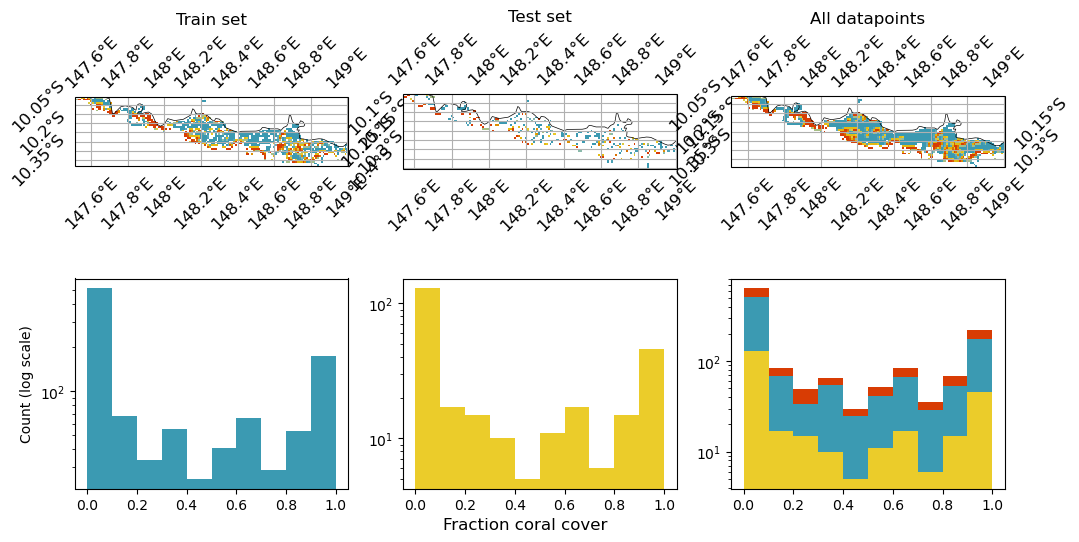

In [17]:
functions_creche.visualise_train_test_points(y_train_df, y_test_df, do_crop_df=True)

# Running model

## Tuning

In [18]:
y_train = y_train_df
y_test = y_test_df
X_train = X_train_df
X_test = X_test_df

In [19]:
### TODO: DASK CLIENT CONSISTENCY
n_workers = 5

def initialise_cluster(n_workers: int=4):
    """
    If cluster with correct number of workers already running, use that one. If not, set one up.

    Args:
        n_workers (int, optional): Number of workers to use. Defaults to 4.

    Returns:
        client: Dask client
    """
    try:
        if client:
            print("Client exists...")
        
        # client = Client(timeout='2s')
        # print("Client exists...")
            return client
            
    except UnboundLocalError:
        print("No current client. Setting up new cluster...")

    cluster = LocalCluster(n_workers=n_workers, scheduler_port=42815)
    client = Client(cluster)

    return client

    # try:
    #     if client:  # client instance exists...
    #         if len(client.scheduler_info()["workers"]) == n_workers:    # ... and has correct number of workers
    #             print("Using existing cluster...")
    #             return client
    #         else:
    #             print("Incorrect number of workers in existing cluster. Closing and creating a new one...")
    #             client = client.close()
    # except:
    #     print("No cluster running...")

    # print("Setting up new cluster...")
    # cluster = LocalCluster(n_workers=n_workers, scheduler_port=42815)
    # client = Client(cluster)
    # return client

# try:
#     client = Client('tcp://localhost:8787', timeout='1s')
# except OSError:
#     cluster = LocalCluster(scheduler_port=8787)
#     client = Client(cluster)
    
# client.restart()
# client

client = initialise_cluster(n_workers=n_workers)
client

No current client. Setting up new cluster...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 260,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42815,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 260
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:34085,Total threads: 52
Dashboard: http://127.0.0.1:40143/status,Memory: 201.53 GiB
Nanny: tcp://127.0.0.1:38529,


In [20]:
client.scheduler_info()

{'type': 'Scheduler',
 'id': 'Scheduler-d1002796-adf8-4db0-9b93-ada2657a13b1',
 'address': 'tcp://127.0.0.1:42815',
 'services': {'dashboard': 8787},
 'started': 1708075549.1220524,
 'workers': {'tcp://127.0.0.1:34085': {'type': 'Worker',
   'id': 0,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/tmp/dask-scratch-space/worker-_3njso1l',
   'name': 0,
   'nthreads': 52,
   'memory_limit': 216396262604,
   'last_seen': 1708075550.2427926,
   'services': {'dashboard': 40143},
   'metrics': {'task_counts': {},
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'digests_total_since_heartbeat': {},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     'incoming_count_total': 0,
     'outgoing_bytes': 0,
     'outgoing_count': 0,
     'outgoing_count_total': 0},
    'event_loop_interval': 0.02,
    'cpu': 0.0,
    'memory': 67108864,
    'time': 1708075549.995812,
    'host_net_io': {'read_bps': 0.0, 'write_bps': 0.0},
    'host_disk_io': {'read_bps': 0.0, 'write_bps': 0.0},
    'num_fds': 18},
   'status': 'running',
   'nanny': 'tcp://127.0.0.1:38529'},
  'tcp://127.0.0.1:36551': {'type': 'Worker',
   'id': 3,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/tmp/dask-scratch-space/worker-30z7bnb5',
   'name': 3,
   'nthreads': 52,
   'memory_limit': 216396262604,
   'last_seen': 1708075550.2522464,
   'services': {'dashboard': 39417},
   'metrics': {'task_counts': {},
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'digests_total_since_heartbeat': {},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     'incoming_count_total': 0,
     'outgoing_bytes': 0,
     'outgoing_count': 0,
     'outgoing_count_total': 0},
    'event_loop_interval': 0.02,
    'cpu': 0.0,
    'memory': 67108864,
    'time': 1708075550.0060065,
    'host_net_io': {'read_bps': 0.0, 'write_bps': 0.0},
    'host_disk_io': {'read_bps': 0.0, 'write_bps': 0.0},
    'num_fds': 18},
   'status': 'running',
   'nanny': 'tcp://127.0.0.1:44859'},
  'tcp://127.0.0.1:36907': {'type': 'Worker',
   'id': 1,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/tmp/dask-scratch-space/worker-lj1zgz6l',
   'name': 1,
   'nthreads': 52,
   'memory_limit': 216396262604,
   'last_seen': 1708075550.2297819,
   'services': {'dashboard': 38367},
   'metrics': {'task_counts': {},
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'digests_total_since_heartbeat': {},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     'incoming_count_total': 0,
     'outgoing_bytes': 0,
     'outgoing_count': 0,
     'outgoing_count_total': 0},
    'event_loop_interval': 0.02,
    'cpu': 0.0,
    'memory': 67108864,
    'time': 1708075549.9832113,
    'host_net_io': {'read_bps': 0.0, 'write_bps': 0.0},
    'host_disk_io': {'read_bps': 0.0, 'write_bps': 0.0},
    'num_fds': 18},
   'status': 'running',
   'nanny': 'tcp://127.0.0.1:39491'},
  'tcp://127.0.0.1:40585': {'type': 'Worker',
   'id': 2,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/tmp/dask-scratch-space/worker-4qf44wd5',
   'name': 2,
   'nthreads': 52,
   'memory_limit': 216396262604,
   'last_seen': 1708075550.2471356,
   'services': {'dashboard': 44497},
   'metrics': {'task_counts': {},
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'digests_total_since_heartbeat': {},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     'incoming_count_total': 0,
     'outgoing_bytes': 0,
     'outgoing_count': 0,
     'outgoing_count_total': 0},
    'event_loop_interval': 0.02,
    'cpu': 0.0,
    'memory': 67108864,
    'time': 1708075550.005826,
    

In [21]:
if client:
    print("clonsing cluster")
    client = client.close()


clonsing cluster


In [22]:
client

In [27]:
# TODO: time each process. Seems to take weirdly long at unusual parts



# client = initialise_cluster(n_workers=int(256/4))
# # initialise local dask cluster
# try:
#     if client or cluster:
#         client.close()
# except NameError:
#     pass

# # TODO: experiment with number of workers
# cluster = LocalCluster(n_workers=4)
# client = Client(cluster)

# model_type="classification"
model_type="regression"
# TODO: make less arbitrary e.g. by making a proportion of the data
n_samples = 200000

# TODO: investigate effect of different thresholds. Regression -> threshold = threshold -> classification?
threshold = 0.25

warnings.filterwarnings(action="ignore", category=FutureWarning)


if model_type == "classification":
    y_train = functions_creche.cont_to_class(y_train, threshold=threshold)
    y_test = functions_creche.cont_to_class(y_test, threshold=threshold)
    custom_scale_pos_weight = (len(y_train)-sum(y_train))/sum(y_train)

    model = xgb.XGBClassifier(verbosity=0)
    
elif model_type == "regression":
    custom_scale_pos_weight = None
    model = xgb.XGBRegressor(verbosity=0)

cluster = LocalCluster(n_workers=4, dashboard_address=":8787")
client = Client(cluster)

param_space = functions_creche.xgb_random_search(custom_scale_pos_weight=custom_scale_pos_weight)

if __name__ == "__main__":
    search = RandomizedSearchCV(model, param_space, cv=5, n_iter=100, verbose=1)
    # TODO: add post-random search grid search
    
    # TODO: sort out saving (or not) to pkl. Will be done when functionalised
    with joblib.parallel_config(backend='dask', verbose=1):
        scaler = MinMaxScaler()
        fit_scaler = scaler.fit(X_train_df[:n_samples])
        X_train_scaled = fit_scaler.transform(X_train_df[:n_samples])
        search.fit(X_train_scaled, y_train[:n_samples])
        
with open(f"models/xgb_cl_best_rerun_dasking.pickle", "wb") as handle:
    pickle.dump(search.best_params_, handle, protocol=-1)

# shut down dask cluster
# client.close()

/home/rt582/miniforge3/envs/coralshift/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45361 instead
  warnings.warn(


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done 490 out of 500 | elapsed: 72.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 75.9min finished


In [28]:
### WANDB
import wandb
import pprint
l
wandb.login()

sweep_config = {
    "method": "random"
}
metric = {
    "name": "loss",
    "goal": "minimize"
}
sweep_config["metric"] = metric

sweep_config["parameters"] = param_space

pprint.pprint(sweep_config)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: orlando-code. Use `wandb login --relogin` to force relogin


{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'booster': ['gbtree', 'gblinear', 'dart'],
                'eta': [0.01, 0.1, 0.3, 0.5],
                'gamma': [0, 0.1, 0.3, 0.5],
                'grow_policy': ['depthwise', 'lossguide'],
                'lambda': [0, 0.1, 0.3, 0.5, 1, 2],
                'max_bin': [256, 512, 1024],
                'max_delta_step': [0, 0.1, 0.3, 0.5],
                'max_depth': [3, 5, 7, 10, 50, 100],
                'max_leaves': [0, 10, 20, 50, 100],
                'min_child_weight': [1, 3, 5, 7],
                'refresh_leaf': [0, 1],
                'sampling_method': ['uniform'],
                'scale_pos_weight': [0.2, 0.4, 0.6, 0.8],
                'subsample': [0.3, 0.5, 0.7, 0.9]}}


In [29]:
sweep_id = wandb.sweep(sweep_config, project="xgboost")

400 response executing GraphQL.
{"errors":[{"message":"Invalid configuration for hyperparameter 'lambda'","path":["upsertSweep"]}],"data":{"upsertSweep":null}}
wandb: ERROR Error while calling W&B API: Invalid configuration for hyperparameter 'lambda' (<Response [400]>)


UsageError: Invalid configuration for hyperparameter 'lambda'

In [ ]:
### GRID SEARCH

search.best_params_

In [ ]:
print("TUNING COMPLETE")


## Training

/home/rt582/miniforge3/envs/coralshift/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43689 instead
  warnings.warn(


scaling data...
fitting model...
Threshold: 0.1


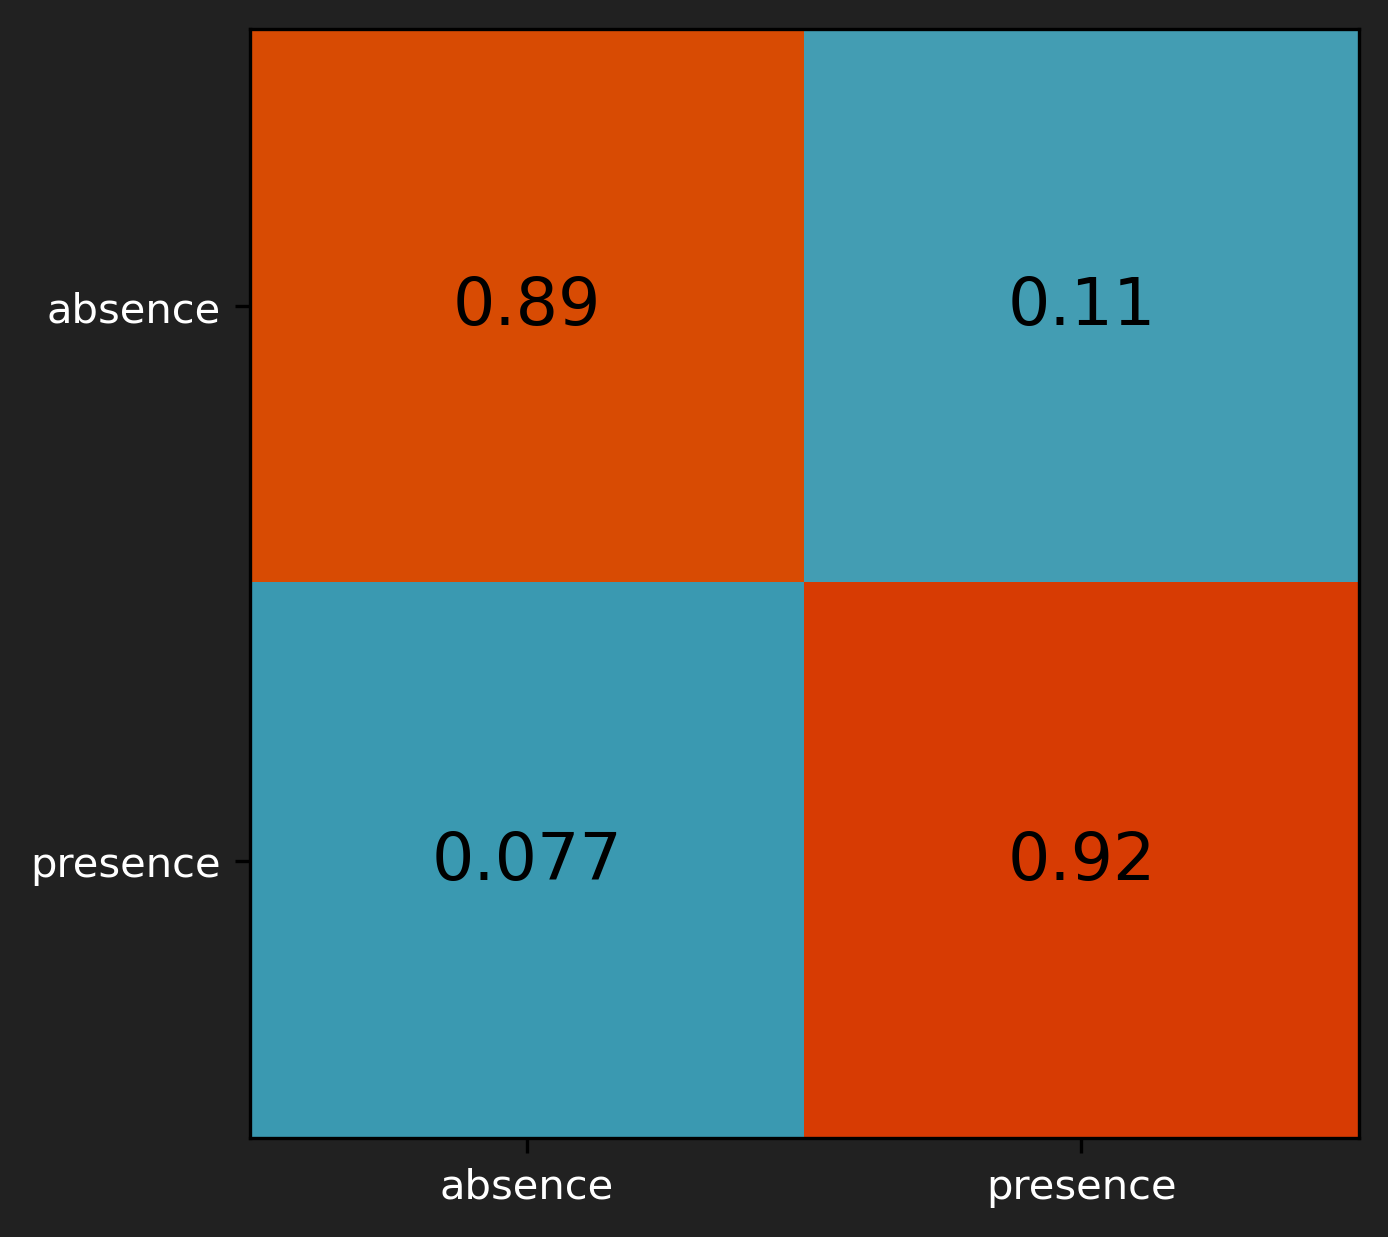

In [60]:
pkl = True
n_samples = 141000
threshold = 0.1

model_type = "regression"

if pkl:
    # fit model with best parameters
    # this shouldn't be necessary once put into more user-friendly pipeline
    pkl_fp = "/maps/rt582/coralshift/models/xgb_cl_best_rerun_dasking.pickle"
    
    with open(pkl_fp, 'rb') as handle:
        best_params = pickle.load(handle)
else:
    best_params = search.best_params_


if model_type == "classification":
    y_train = cont_to_class(y_train, threshold=threshold)
    y_test = cont_to_class(y_test, threshold=threshold)

    model = xgb.XGBClassifier(**best_params)
else:
    model = xgb.XGBRegressor(**best_params)


cluster = LocalCluster(n_workers=4, dashboard_address=":8787")
client = Client(cluster)

# TODO: is this training and testing on same data??
with joblib.parallel_backend('dask'):
    print("scaling data...")
    # TODO: optional change
    scaler = MinMaxScaler()
    fit_scaler = scaler.fit(X_train_df[:n_samples])
    X_train_scaled = fit_scaler.transform(X_train_df[:n_samples])

    dtrain = xgb.DMatrix(X_train_scaled, y_train_df[:n_samples])
    print("fitting model...")
    # model.fit(X_train_scaled, y_train_df[:n_samples])
    # model.fit(dX_train, dy_train)
    bst = xgb.train(best_params, dtrain)


thresholded_pred = functions_creche.cont_to_class(y_test_pred[:n_samples], threshold=threshold)
thresholded_actual = functions_creche.cont_to_class(y_test[:n_samples], threshold=threshold)

# formatting confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(dpi=300)

cmap = spatial_plots.get_cbar()


cm = confusion_matrix(thresholded_actual, thresholded_pred, labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"],
                             )

functions_creche.customize_plot_colors(fig,ax)
disp.plot(ax=ax, cmap=cmap, text_kw={"c":"k", "size": 16, "visible": True}, colorbar=False)

ax.set_xlabel('');
ax.set_ylabel('');
print("Threshold: {}".format(threshold))

In [56]:
dtrain.num_row()

141000

In [57]:
X_test_scaled = fit_scaler.transform(X_test_df[:n_samples])
dtest = xgb.DMatrix(X_test_scaled, y_test_df[:n_samples])

prediction = bst.predict(dtest)

rmse = sklmetrics.root_mean_squared_error(y_test_df[:n_samples], prediction)
print(rmse)

0.17114694002216363


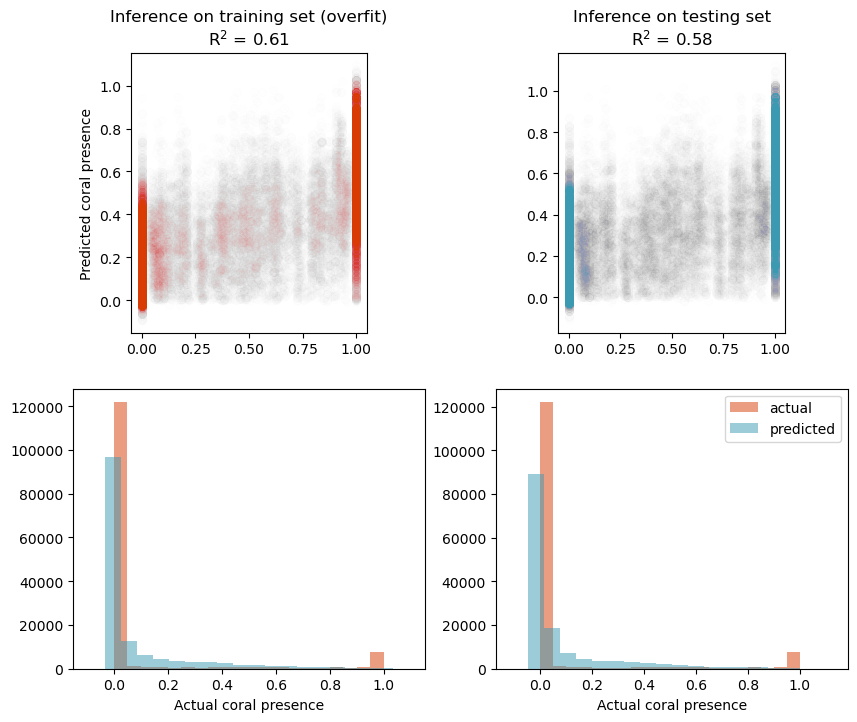

In [35]:
# scale (train and) test data
# overfitting
y_train_pred = bst.predict(dtrain)
# actual prediction
y_test_pred = bst.predict(dtest)

f, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0,0].scatter(y_train_df[:n_samples], y_train_pred, alpha=0.005, color = "#d83c04")
ax[0,1].scatter(y_test_df[:n_samples], y_test_pred, alpha=0.005, color = "#3B9AB2")

n_bins = 20
ax[1,0].hist(y_train_df[:n_samples], bins=n_bins, color="#d83c04", alpha=0.5, label="actual");
ax[1,0].hist(y_train_pred[:n_samples], bins=n_bins, color="#3B9AB2", alpha=0.5, label="predicted");
ax[1,1].hist(y_test_df[:n_samples], bins=n_bins, color="#d83c04", alpha=0.5, label="actual");
ax[1,1].hist(y_test_pred[:n_samples], bins=n_bins, color="#3B9AB2", alpha=0.5, label="predicted");

# calculate metric(s)
overfit_r2 = sklmetrics.r2_score(y_train_df[:n_samples], y_train_pred)
inference_r2 = sklmetrics.r2_score(y_test_df[:n_samples], y_test_pred)

ax[0,0].set_title("Inference on training set (overfit)\nR$^2$ = {:.2f}".format(overfit_r2))
ax[0,1].set_title("Inference on testing set\nR$^2$ = {:.2f}".format(inference_r2))

ax[1,0].set_xlabel("Actual coral presence")
ax[1,1].set_xlabel("Actual coral presence")
ax[0,0].set_ylabel("Predicted coral presence")
plt.legend()

for a in ax.ravel()[:2]:
    a.set_aspect('equal')

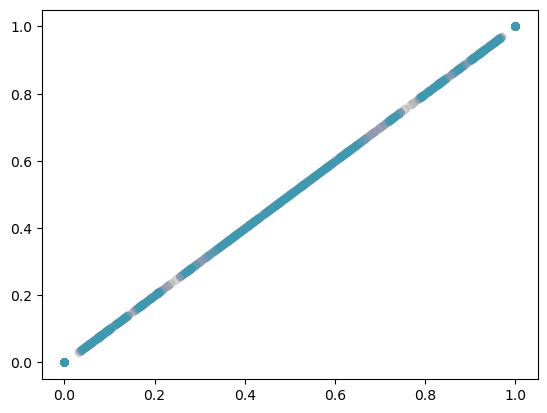

In [39]:
plt.scatter(y_test_df[:n_samples], y_test_df[:n_samples], alpha=0.005, color = "#3B9AB2")

Threshold: 0.25


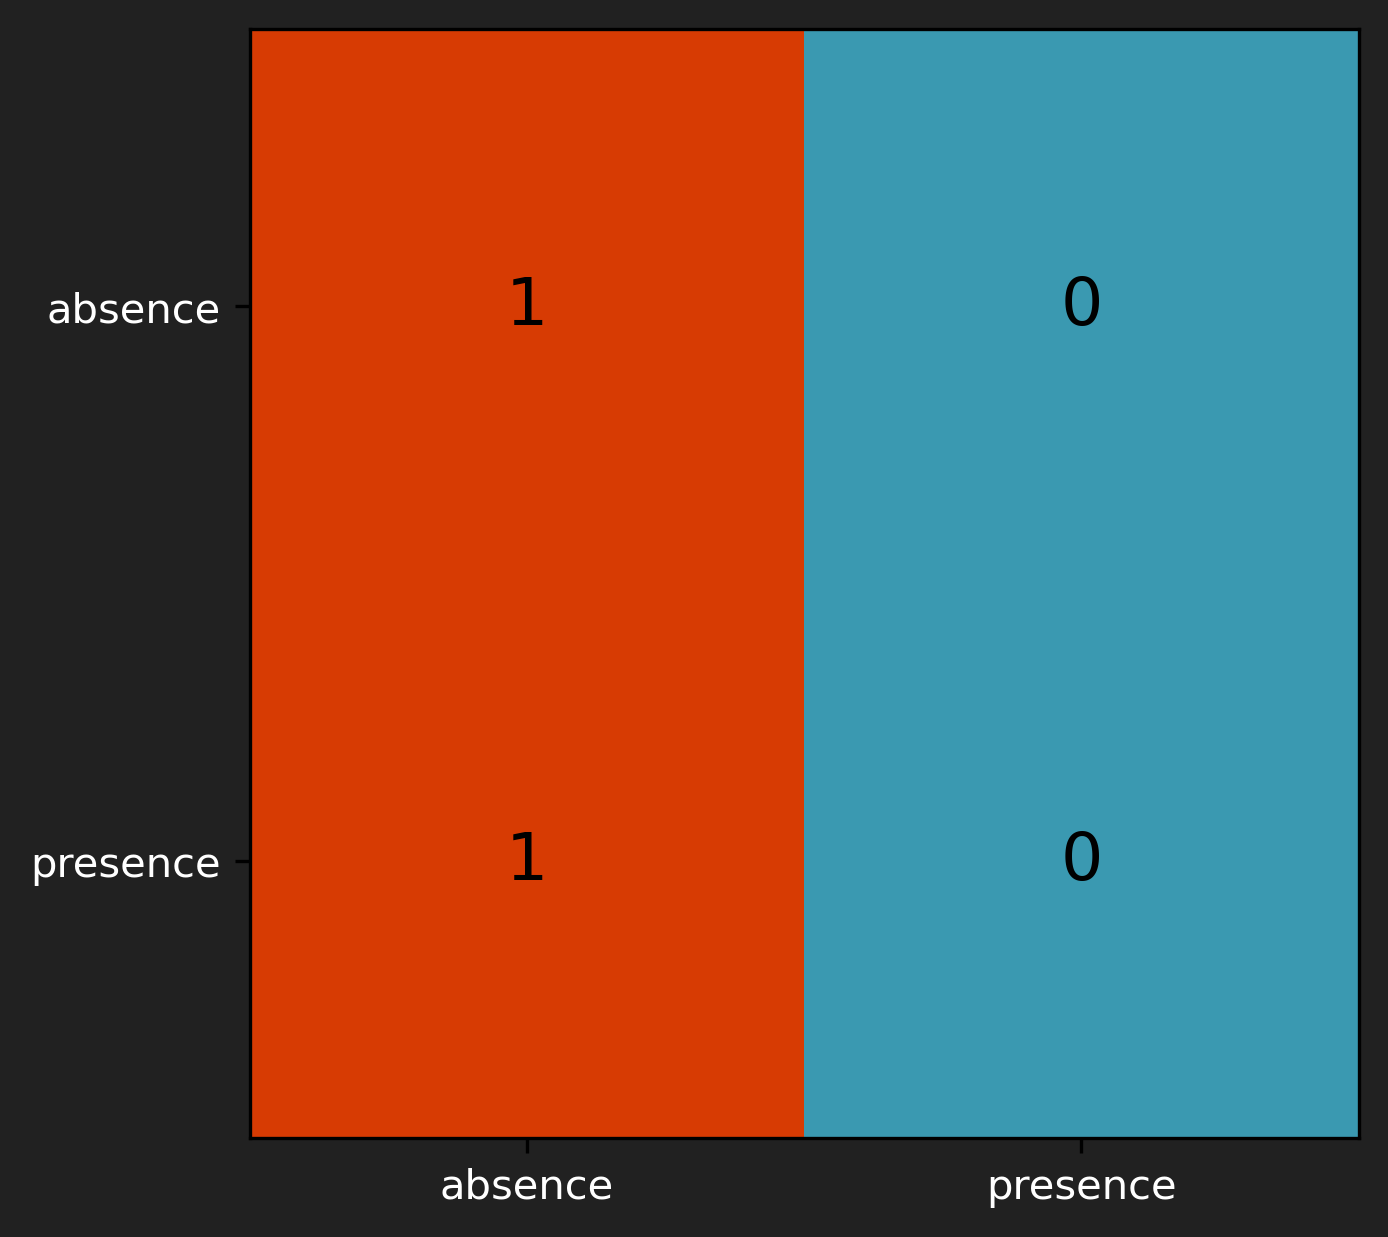

In [52]:

# zero skill (all predicted zero)
thresholded_pred = np.zeros(n_samples)
# zero skill (all predicted 0 or 1 with 50-50 chance)
# thresholded_pred = np.random.choice([0, 1], n_samples)

thresholded_actual = functions_creche.cont_to_class(y_test[:n_samples], threshold=threshold)

# formatting confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(dpi=300)

cmap = spatial_plots.get_cbar()


cm = confusion_matrix(thresholded_actual, thresholded_pred, labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"],
                             )

functions_creche.customize_plot_colors(fig,ax)
disp.plot(ax=ax, cmap=cmap, text_kw={"c":"k", "size": 16, "visible": True}, colorbar=False)

ax.set_xlabel('');
ax.set_ylabel('');
print("Threshold: {}".format(threshold))

Threshold: 0.01


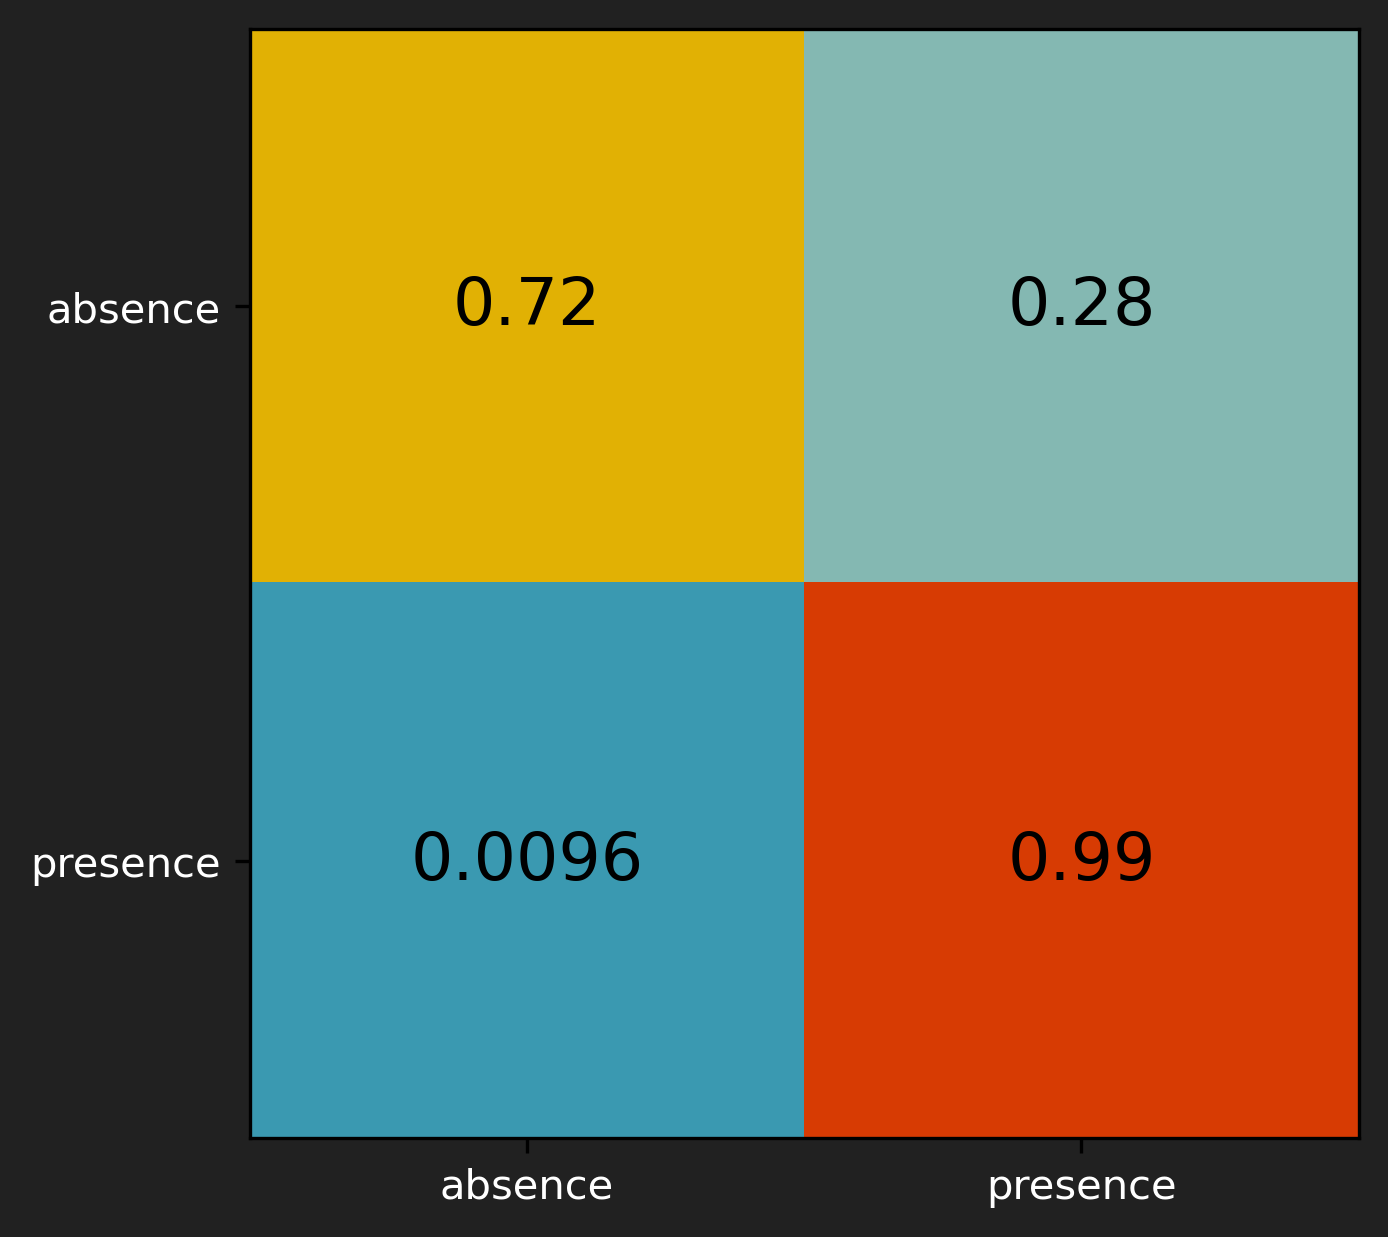

In [54]:
threshold = 0.01

thresholded_pred = functions_creche.cont_to_class(y_test_pred[:n_samples], threshold=threshold)
thresholded_actual = functions_creche.cont_to_class(y_test[:n_samples], threshold=threshold)

# formatting confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(dpi=300)

cmap = spatial_plots.get_cbar()


cm = confusion_matrix(thresholded_actual, thresholded_pred, labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"],
                             )

functions_creche.customize_plot_colors(fig,ax)
disp.plot(ax=ax, cmap=cmap, text_kw={"c":"k", "size": 16, "visible": True}, colorbar=False)

ax.set_xlabel('');
ax.set_ylabel('');
print("Threshold: {}".format(threshold))

## Couce graphs

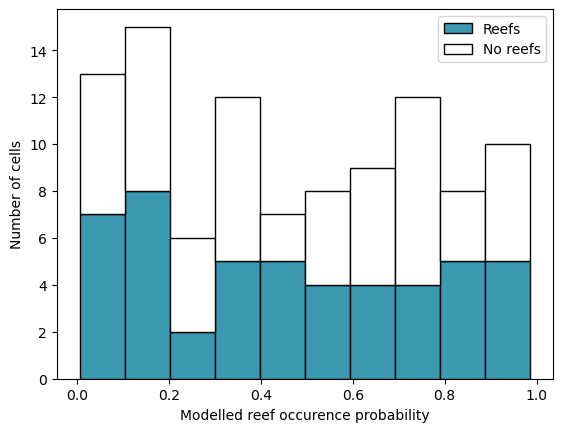

In [36]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

# Example data: N probability values and corresponding presence/absence values
np.random.seed(42)
N = 100
prob_values = np.random.rand(N)
presence_absence = np.random.choice([0, 1], size=N)

# Separate the probability values based on presence/absence
prob_values_present = prob_values[presence_absence == 1]
prob_values_absent = prob_values[presence_absence == 0]

# Plot the stacked histogram with a blue outline for "Reefs" bars with probabilities below 0.5
ax.hist([prob_values_present, prob_values_absent],
        histtype="bar", stacked=True, color=["#3B9AB2", "white"],
        bins=10, label=["Reefs", "No reefs"],
        edgecolor="k")

# Add labels and legend
plt.xlabel('Modelled reef occurence probability')
plt.ylabel("Number of cells")
plt.legend()

# Show the plot
plt.show()


In [37]:
patches

NameError: name 'patches' is not defined

In [ ]:
prob_values_present

array([0.95071431, 0.15601864, 0.05808361, 0.86617615, 0.60111501,
       0.30424224, 0.43194502, 0.29214465, 0.36636184, 0.45606998,
       0.78517596, 0.51423444, 0.60754485, 0.17052412, 0.06505159,
       0.94888554, 0.96563203, 0.80839735, 0.30461377, 0.09767211,
       0.44015249, 0.12203823, 0.03438852, 0.66252228, 0.96958463,
       0.93949894, 0.19598286, 0.04522729, 0.27134903, 0.54269608,
       0.14092422, 0.80219698, 0.77224477, 0.19871568, 0.00552212,
       0.81546143, 0.72900717, 0.07404465, 0.11586906, 0.86310343,
       0.62329813, 0.33089802, 0.31098232, 0.47221493, 0.5612772 ,
       0.77096718, 0.4937956 , 0.52273283, 0.10789143])

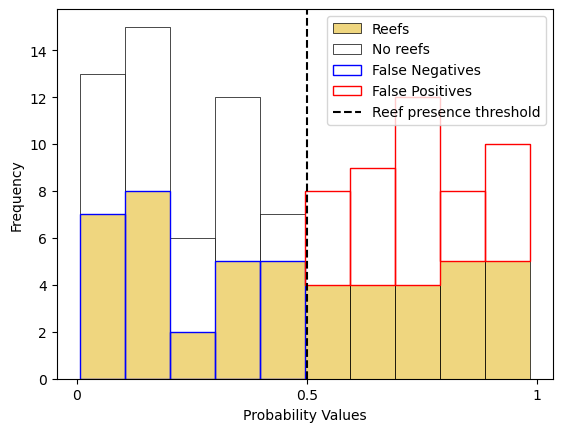

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()

# Example data: N probability values and corresponding presence/absence values
np.random.seed(42)
N = 100
prob_values = np.random.rand(N)
presence_absence = np.random.choice([0, 1], size=N)

# Separate the probability values based on presence/absence
prob_values_present = prob_values[presence_absence == 1]
prob_values_absent = prob_values[presence_absence == 0]

# Plot the stacked histogram with a blue outline for "Reefs" bars with probabilities below 0.5
n, bins, patches = ax.hist([prob_values_present, prob_values_absent],
                            histtype="bar", stacked=True, color=[(225/255,175/255,0,0.5), "white"],
                            bins=10, label=["Reefs", "No reefs"],
                            edgecolor="k", linewidth=0.5)

# Add labels and legend
plt.xlabel('Probability Values')
plt.ylabel('Frequency')

present_ticker, absent_ticker = 0, 0
for i, (rect_present, rect_absent) in enumerate(zip(patches[0], patches[1])):
    (x_present, y_present), width_present, height_present = rect_present.get_xy(), rect_present.get_width(), rect_present.get_height()
    (x_absent, y_absent), width_absent, height_absent = rect_absent.get_xy(), rect_absent.get_width(), rect_absent.get_height()

    if x_present < 0.4:
        if present_ticker == 0:
            ax.add_patch(Rectangle((x_present, y_present), width_present, height_present, linewidth=1, edgecolor='blue', facecolor='none', label="False Negatives"))
        else:
            ax.add_patch(Rectangle((x_present, y_present), width_present, height_present, linewidth=1, edgecolor='blue', facecolor='none'))
        present_ticker += 1

    if x_absent > 0.45:
        if absent_ticker == 0:
            ax.add_patch(Rectangle((x_absent, y_absent), width_absent, height_absent, linewidth=1, edgecolor='red', facecolor='none', label="False Positives"))
        else:
            ax.add_patch(Rectangle((x_absent, y_absent), width_absent, height_absent, linewidth=1, edgecolor='red', facecolor='none'))
        absent_ticker += 1

ax.set_xticks([0, 0.5, 1])
ax.set_xticklabels([0, 0.5, 1])
ax.axvline(0.5, 0, 100, color="black", linestyle="--", label="Reef presence threshold")

plt.legend(loc="upper right")


# Show the plot
plt.show()


In [ ]:
dy_train.get_data()

<10x1 sparse matrix of type '<class 'numpy.float32'>'
	with 10 stored elements in Compressed Sparse Row format>

In [ ]:
dX_train = xgb.DMatrix(X_train_df[:n_samples])


In [ ]:
dX_train = xgb.DMatrix(X_train_df[:n_samples], label=y_train_df[:n_samples])
dX_test = xgb.DMatrix(X_test_df[:n_samples], label=y_test_df[:n_samples]) 

In [ ]:
wandb.use_artifact('wandb/intro/dermatology_data:v0', type='dataset').download('.')


wandb:   1 of 1 files downloaded.  


'.'

In [ ]:
# add another config to the wandb run
num_round = 100
wandb.config["num_round"] = num_round
wandb.config["data_shape"] = X_train_df.shape

watchlist = [(dX_train, "train"), (dX_test, "test")]


In [ ]:
bst = xgb.train(
    best_params, dX_train, num_round, evals=watchlist, num_
    callbacks=[WandbCallback()]
)

[0]	train-rmse:0.05480	test-rmse:0.36784
[1]	train-rmse:0.05361	test-rmse:0.36601
[2]	train-rmse:0.05369	test-rmse:0.36684
[3]	train-rmse:0.05226	test-rmse:0.36650
[4]	train-rmse:0.05080	test-rmse:0.36565
[5]	train-rmse:0.04956	test-rmse:0.36634
[6]	train-rmse:0.04846	test-rmse:0.36465
[7]	train-rmse:0.04717	test-rmse:0.36439
[8]	train-rmse:0.04585	test-rmse:0.36364
[9]	train-rmse:0.04473	test-rmse:0.36431
[10]	train-rmse:0.04360	test-rmse:0.36281
[11]	train-rmse:0.04244	test-rmse:0.36130
[12]	train-rmse:0.04130	test-rmse:0.36108
[13]	train-rmse:0.04133	test-rmse:0.36163
[14]	train-rmse:0.04024	test-rmse:0.36016
[15]	train-rmse:0.03922	test-rmse:0.35879
[16]	train-rmse:0.03832	test-rmse:0.35936
[17]	train-rmse:0.03745	test-rmse:0.35801
[18]	train-rmse:0.03748	test-rmse:0.35851
[19]	train-rmse:0.03648	test-rmse:0.35713
[20]	train-rmse:0.03565	test-rmse:0.35656
[21]	train-rmse:0.03569	test-rmse:0.35698
[22]	train-rmse:0.03473	test-rmse:0.35636
[23]	train-rmse:0.03479	test-rmse:0.35677
[2

KeyboardInterrupt: 

In [ ]:
import wandb
import os
from wandb.xgboost import WandbCallback

os.environ["WANDB_NOTEBOOK_NAME"] = "pipeline.ipynb"
wandb.login()

wandb.init(project="sklearn")

# wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


## Predicting

In [ ]:
# scale (train and) test data
# overfitting
X_train_scaled = scaler.transform(X_train_df[:n_samples])
y_train_pred = model.predict(X_train_scaled)
# actual prediction
X_test_scaled = scaler.transform(X_test_df[:n_samples])
y_test_pred = model.predict(X_test_scaled)

f1_train = sklmetrics.f1_score(y_train_df[:n_samples], y_train_pred)
f1_test = sklmetrics.f1_score(y_test_df[:n_samples], y_test_pred)

wandb.log({"f1_train": f1_train, "f1_test": f1_test})

ValueError: continuous is not supported

# Evaluating

## Regression plots

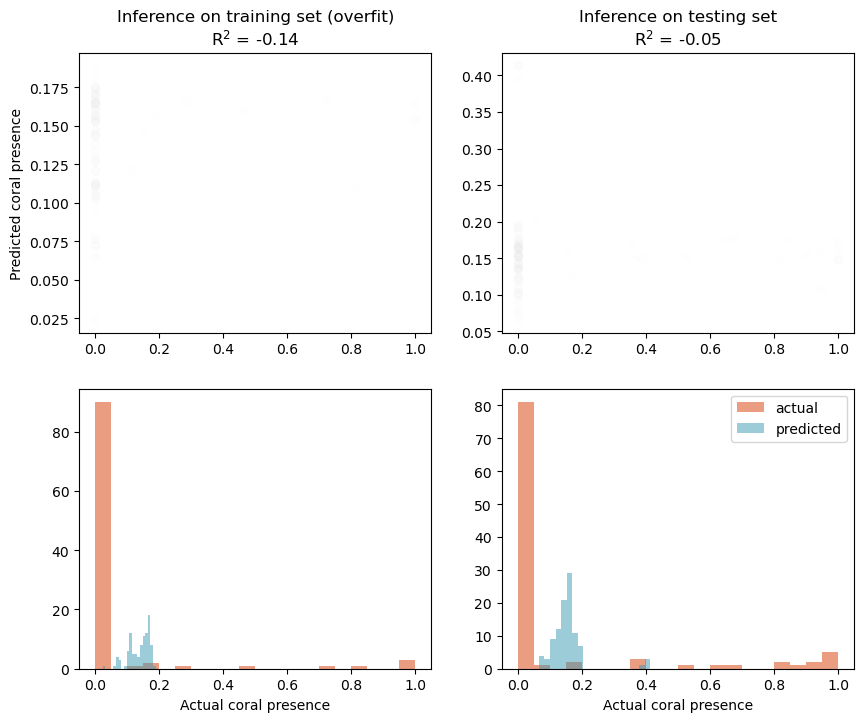

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0,0].scatter(y_train[:n_samples], y_train_pred, alpha=0.005, color = "#d83c04")
ax[0,1].scatter(y_test[:n_samples], y_test_pred, alpha=0.005, color = "#3B9AB2")

n_bins = 20
ax[1,0].hist(y_train[:n_samples], bins=n_bins, color="#d83c04", alpha=0.5, label="actual");
ax[1,0].hist(y_train_pred[:n_samples], bins=n_bins, color="#3B9AB2", alpha=0.5, label="predicted");
ax[1,1].hist(y_test[:n_samples], bins=n_bins, color="#d83c04", alpha=0.5, label="actual");
ax[1,1].hist(y_test_pred[:n_samples], bins=n_bins, color="#3B9AB2", alpha=0.5, label="predicted");

# calculate metric(s)
overfit_r2 = sklmetrics.r2_score(y_train[:n_samples], y_train_pred)
inference_r2 = sklmetrics.r2_score(y_test[:n_samples], y_test_pred)

ax[0,0].set_title("Inference on training set (overfit)\nR$^2$ = {:.2f}".format(overfit_r2))
ax[0,1].set_title("Inference on testing set\nR$^2$ = {:.2f}".format(inference_r2))

ax[1,0].set_xlabel("Actual coral presence")
ax[1,1].set_xlabel("Actual coral presence")
ax[0,0].set_ylabel("Predicted coral presence")
plt.legend()

# for a in ax:
#     a.set_aspect('equal', 'box')

Threshold: 0.25


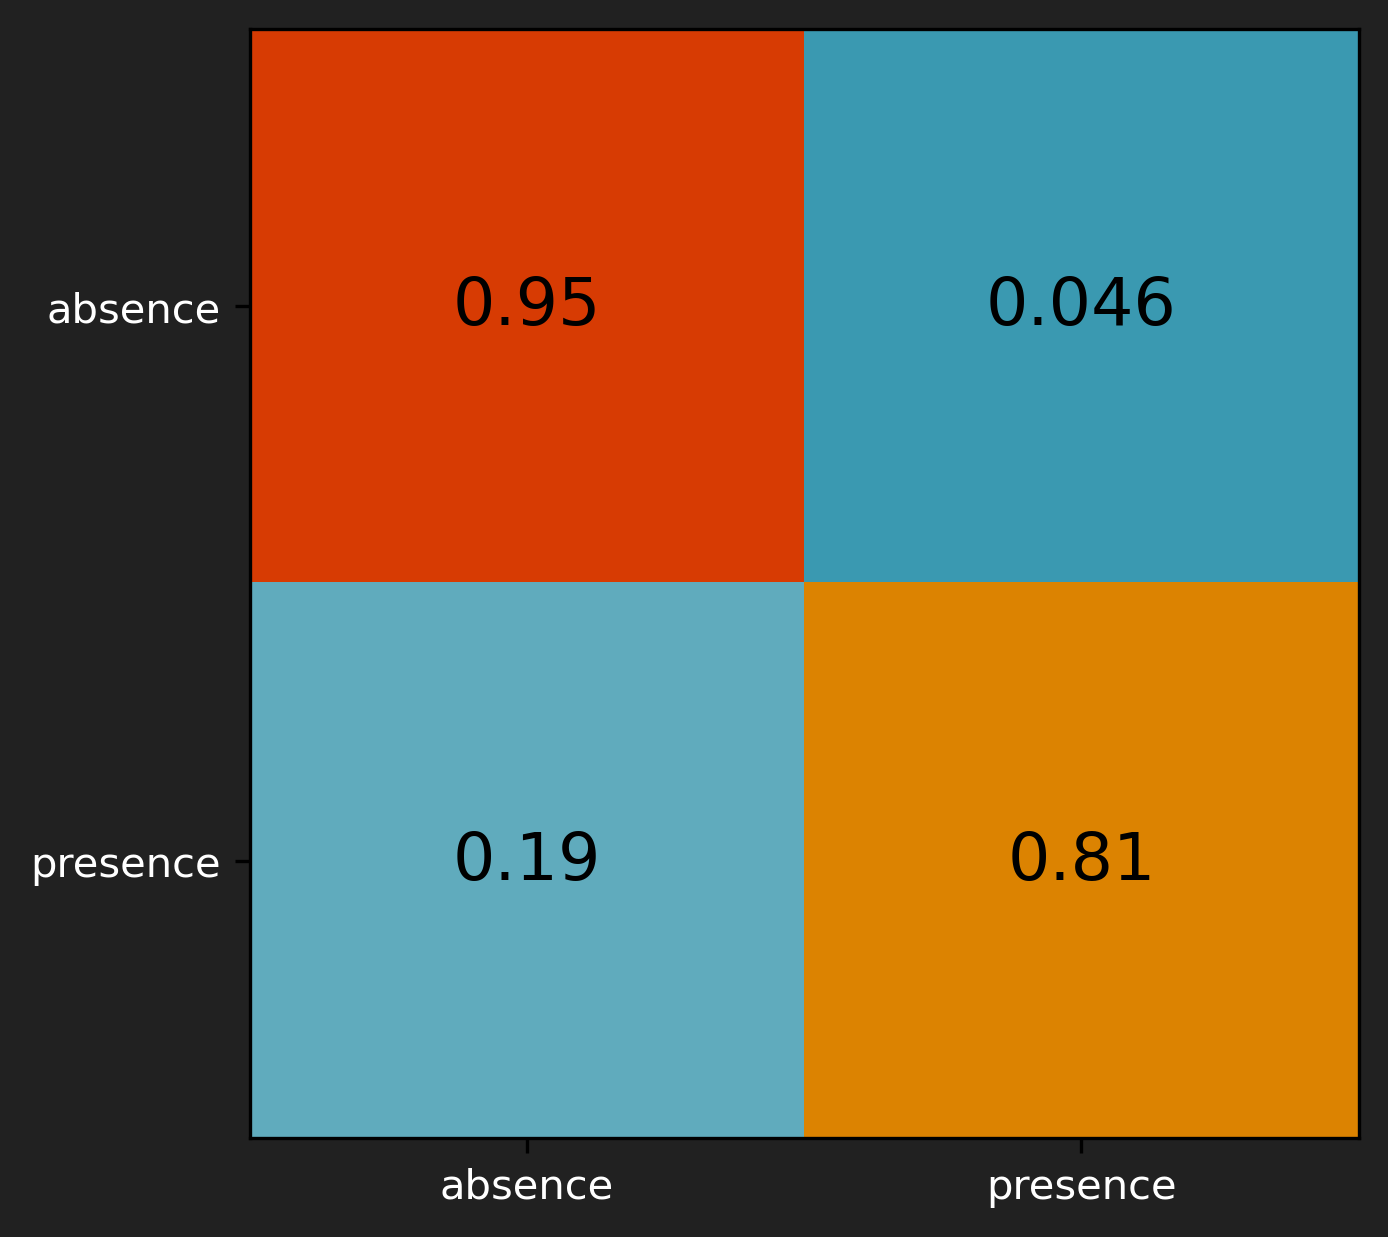

In [ ]:
threshold = 0.25

thresholded_pred = functions_creche.cont_to_class(y_test_pred, threshold=threshold)
thresholded_actual = functions_creche.cont_to_class(y_test, threshold=threshold)

# formatting confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(dpi=300)

cmap = spatial_plots.get_cbar()


cm = confusion_matrix(thresholded_actual, thresholded_pred, labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"],
                             )

functions_creche.customize_plot_colors(fig,ax)
disp.plot(ax=ax, cmap=cmap, text_kw={"c":"k", "size": 16, "visible": True}, colorbar=False)

ax.set_xlabel('');
ax.set_ylabel('');
print("Threshold: {}".format(threshold))

## Confusion matrix

In [ ]:
# formatting confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(dpi=300)

cmap = spatial_plots.get_cbar()


cm = confusion_matrix(y_test, functions_creche.cont_to_class(y_test_pred, 0.5), labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"],
                              # , cmap=cmap
                             )

functions_creche.customize_plot_colors(fig,ax)
disp.plot(ax=ax, cmap=cmap, text_kw={"c":"k", "size": 16, "visible": True}, colorbar=False)

ax.set_xlabel('')
ax.set_ylabel('')

plt.yticks(rotation=90)

balanced_accuracy_score = sklmetrics.balanced_accuracy_score(y_test, y_test_pred)
accuracy_score = sklmetrics.accuracy_score(y_test, y_test_pred)
f1_score = sklmetrics.f1_score(y_test, y_test_pred)

print("balanced_accuracy_score", balanced_accuracy_score)
print("accuracy_score", accuracy_score)
print("f1_score", f1_score)


## Feature importance

In [ ]:
model.feature_importances_[sorted_idx][10:]

In [ ]:
nfeatures=10
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train_df.columns[sorted_idx][-nfeatures:], model.feature_importances_[sorted_idx][-nfeatures:]t)
plt.xlabel("Xgboost Feature Importance")

In [ ]:
# feature importance
# print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_);
plt.show()

In [ ]:
booster = model.get_booster()
importance = booster.get_score(importance_type="gain")
print(importance)

In [ ]:
plot_importance(importance, max_num_features=100, importance_type='', show_values=True)

In [ ]:
# fi_dict = dict(zip(X_df.columns, model.feature_importances_))
sorted_f1_dict = dict(reversed(sorted(fi_dict.items(), key=lambda item: item[1])))

In [ ]:
nfeatures = -1
# Extract keys and values for plotting
keys = list(sorted_f1_dict.keys())[:nfeatures]
values = list(sorted_f1_dict.values())[:nfeatures]


f,ax = plt.subplots(dpi=300, figsize=(12,2))
# Creatbarse bar chart
bars = ax.bar(keys, values, color="#3B9AB2")
bars[0].set_color("#E1AF00")
bars[1].set_color("#E1AF00")
ax.set_xticklabels([])
ax.set_ylabel(f"F score\nFeature Importance\n\n\n Features")
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# f.tight_layout()
functions_creche.customize_plot_colors(f,ax)
# ax.axis("off")

In [ ]:
fi_dict = model.get_booster().get_fscore()
xgboost.plot_importance(model, max_num_features=20)

## Testing on area outside training

### Inference on area

In [ ]:
# testing on specific area (outside of training data)
test_ds = xa.open_dataset(train_nc_fps[-2])


In [ ]:
# X_df, y_df = ds_to_ml_ready(test_ds)

# X_df = pd.concat(train_Xs, axis=0)
# y_df = pd.concat(train_ys, axis=0)

predictions = model.predict(X_df.to_numpy())
y_cont = cont_to_class(y_df.to_numpy(), 0.25)

# Convert the multi-index DataFrame X to a NumPy array
X_np = X_df.to_numpy()

# Check shapes to ensure compatibility for concatenation
if len(X_np) == len(predictions):
    # Concatenate X (as a NumPy array) with y along the columns (axis=1)
    concatenated_data = np.concatenate((X_np, predictions[:, np.newaxis]), axis=1)
    # Creating a new DataFrame if needed
    concatenated_df = pd.DataFrame(concatenated_data, index=X_df.index, columns=list(X_df.columns) + ['predictions'])
else:
    print("Lengths of X and y do not match")

out = concatenated_df.to_xarray()


### Reforming xarray

In [ ]:
predictions = model.predict(X_test_df.to_numpy())
y_cont = cont_to_class(y_test_df.to_numpy(), 0.25)

# Convert the multi-index DataFrame X to a NumPy array
# TODO: why doing this?
X_np = X_test_df.to_numpy()

# Check shapes to ensure compatibility for concatenation
if len(X_np) == len(predictions):
    # Concatenate X (as a NumPy array) with y along the columns (axis=1)
    concatenated_data = np.concatenate((X_np, predictions[:, np.newaxis]), axis=1)
    # Creating a new DataFrame if needed
    concatenated_df = pd.DataFrame(concatenated_data, index=X_test_df.index, columns=list(X_test_df.columns) + ['predictions'])
else:
    print("Lengths of X and y do not match")


out = concatenated_df.to_xarray()

sorted = out["predictions"].sortby("longitude").sortby("latitude")
# fill any nan values with 0
out_vis = sorted.fillna(0)

In [ ]:
# # TODO: may be legacy, may be testing on whole area
# # reformed = pd.concat([X_df, pd.Series(predictions)], axis=1

# # Convert the multi-index DataFrame X to a NumPy array
# X_np = X_df.to_numpy()

# # Check shapes to ensure compatibility for concatenation
# if len(X_np) == len(predictions):
#     # Concatenate X (as a NumPy array) with y along the columns (axis=1)
#     concatenated_data = np.concatenate((X_np, predictions[:, np.newaxis]), axis=1)
#     # Creating a new DataFrame if needed
#     concatenated_df = pd.DataFrame(concatenated_data, index=X_df.index, columns=list(X_df.columns) + ['predictions'])
# else:
#     print("Lengths of X and y do not match")

### Visualising

In [ ]:
f,ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
spatial_plots.plot_spatial(out_vis, fax=(f,ax), title="", orient_colorbar="horizontal", cbar=False)

ax.axis("off")
customize_plot_colors(f,ax)
plt.title("")

### Comparing results

In [ ]:
f,ax=plt.subplots(dpi=300, subplot_kw={"projection": ccrs.PlateCarree()})

spatial_plots.plot_spatial(
    out_vis.sel(latitude=slice(-15,-8), longitude=slice(142.5,144.5)), 
    fax=(f,ax), title="", cbar=False, presentation=True)

f2,ax2=plt.subplots(dpi=300, subplot_kw={"projection": ccrs.PlateCarree()})

# TODO: casting ground truth to binary?
binary = xa.where(high_res_ds["unep_coral_presence"] != 0, 1, 0)
spatial_plots.plot_spatial(
    binary.sel(latitude=slice(-15,-8), longitude=slice(142.5,144.5)), 
    fax=(f2,ax2), title="", cbar=False, presentation=True)

f3,ax3=plt.subplots(dpi=300, subplot_kw={"projection": ccrs.PlateCarree()})
spatial_plots.plot_spatial(
    high_res_ds["unep_coral_presence"].sel(latitude=slice(-15,-8), longitude=slice(142.5,144.5)), 
    fax=(f3,ax3), title="", cbar=True, presentation=True)


In [ ]:
print(out_vis.latitude.values[:5])
print(np.sum(binary))

In [ ]:
functions_creche.resample_xa_d(out_vis, lat_range=lat_lims, lon_range=lon_lims, resolution_lat = 0.5, resolution_lon = 0.5)

In [ ]:
lat_lims = spatial_data.xarray_coord_limits(out_vis, "latitude")
lon_lims = spatial_data.xarray_coord_limits(out_vis, "longitude")

f,ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)

spatial_plots.plot_spatial(
    functions_creche.resample_xa_d(out_vis, lat_range=lat_lims, lon_range=lon_lims, resolution_lat = 0.1, resolution_lon = 0.1, resample_method="nearest"),
    fax=(f,ax), presentation=True)

customize_plot_colors(f,ax)



In [ ]:
lat_lims = spatial_data.xarray_coord_limits(out_vis, "latitude")
lon_lims = spatial_data.xarray_coord_limits(out_vis, "longitude")

f,ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)

spatial_plots.plot_spatial(
    functions_creche.resample_xa_d(out_vis, lat_range=lat_lims, lon_range=lon_lims, resolution_lat = 1, resolution_lon = 1, resample_method="zero"),
    fax=(f,ax), presentation=True)

customize_plot_colors(f,ax)



In [ ]:
sklmetrics.f1_score(y_cont, predictions)

In [ ]:
fig, ax = plt.subplots(dpi=300)

cmap = spatial_plots.get_cbar("lim")


cm = confusion_matrix(predictions, y_cont, labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"],
                              # , cmap=cmap
                             )

customize_plot_colors(fig,ax)
disp.plot(ax=ax, cmap=cmap)


balanced_accuracy_score = sklmetrics.balanced_accuracy_score(y_cont, predictions)
accuracy_score = sklmetrics.accuracy_score(y_cont, predictions)
f1_score = sklmetrics.f1_score(y_cont, predictions)

print("balanced_accuracy_score", balanced_accuracy_score)
print("accuracy_score", accuracy_score)
print("f1_score", f1_score)

# Evaluating effect of resolution

Involves upsampling, rerunning the training and testing, and recording various metrics

In [ ]:
# TODO: automate!!

resolutions = [
    # 1, 0.5, 0.1
    # 0.25, 0.05
    0.01
]




def process_df_for_ml(
    df: pd.DataFrame, ignore_vars: list[str], drop_all_nans: bool = True
) -> pd.DataFrame:
    # drop ignored vars
    df = df.drop(columns=list(set(ignore_vars).intersection(df.columns)))

    if drop_all_nans:
        # remove rows which are all nans
        df = utils.drop_nan_rows(df)
    # onehot encoode any remaining nans
    df["onehotnan"] = df.isnull().any(axis=1).astype(int)
    # fill nans with 0
    df = df.fillna(0)

    # flatten dataset for row indexing and model training
    return df



def xa_dss_to_df(
    xa_dss: list[xa.Dataset],
    bath_mask: bool = True,
    res: float = 1,
    ignore_vars: list = ["spatial_ref", "band", "depth"],
    drop_all_nans: bool = True,
):
    dfs = []
    
    limits_dict = {
        1: [-2000,0],
        0.5: [-1000,0],
        0.25: [-500,0],
        0.1: [-80,0],
        0.05: [-60,0],
        0.01: [-20,0],
    }
    for xa_ds in xa_dss:
        
        
        if bath_mask:
            print(limits_dict[res])
            # set all values outside of the shallow water region to nan for future omission
            shallow_mask = spatial_data.generate_var_mask(xa_ds,mask_var="elevation",
                                                          limits=limits_dict[res]
                                                         )
            xa_ds = xa_ds.where(shallow_mask, np.nan)

        # compute out dasked chunks, send type to float32, stack into df, drop any datetime columns
        df = (
            xa_ds.stack(points=("latitude", "longitude"))
            .compute()
            .astype("float32")
            .to_dataframe()
        )
        # drop temporal columns
        df = df.drop(columns=list(df.select_dtypes(include="datetime64").columns))
        df = process_df_for_ml(df, ignore_vars=ignore_vars, drop_all_nans=drop_all_nans)

        dfs.append(df)
    return dfs



def generate_split(ds, res):
    
    # flatten datasets to pandas dataframes and process
    flattened_data_dfs = xa_dss_to_df([ds], bath_mask=True, res=res)
    # generate training and testing coordinates

    # normalise dataframe via min/max scaling
    normalised_dfs = [
        (flattened_data - flattened_data.min())
        / (flattened_data.max() - flattened_data.min())
        for flattened_data in flattened_data_dfs
    ]

    y = normalised_dfs[0]["unep_coral_presence"].to_numpy()
    X = normalised_dfs[0].loc[:, normalised_dfs[0].columns != 'unep_coral_presence'].to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


def train_model(model_type: str, X_train, y_train, cv=3, n_iter=50, n_samples=-1):
    cluster = LocalCluster(n_workers=4)
    client = Client(cluster)

    if model_type == "classification":
        y_train = cont_to_class(y_train, threshold=threshold)
        y_test = cont_to_class(y_test, threshold=threshold)

        model = xgb.XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train))
    
    elif model_type == "regression":
        model = xgb.XGBRegressor(
            n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train)
        )

    class_counts = np.bincount(y_train)
    total_samples = len(y_train)

    class_weight = {
        0: total_samples / (2 * class_counts[0]),
        1: 5*total_samples / (2 * class_counts[1])
    }

    param_space = {
        'bootstrap': [True, False],
        'ccp_alpha': [0.0, 0.1, 0.2],
        'class_weight': ['balanced', class_weight],
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 7, 10, 50, 100],
        'max_features': ['sqrt', 'log2'],
        'max_leaf_nodes': [None, 5, 10, 20],
    #     'max_samples': [None, 0.5, 0.7, 0.9],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'oob_score': [True, False],
        'random_state': [42],  # Add different seed values if desired
    #     'warm_start': [True, False]
        # Add more parameters and ranges as needed
    }

    model = xgb.XGBClassifier()
    search = RandomizedSearchCV(model, param_space, cv=cv, n_iter=n_iter, verbose=2, n_jobs=-1)
    
    with joblib.parallel_backend('dask'):
        search.fit(X_train[:n_samples], y_train[:n_samples])
    client.close()
    
    return search.best_params_, search



def models_at_resolutions(high_res_ds, resolutions:list, model_type, cv, n_iter, n_samples, threshold=0.25):
    
    models = []
    best_param_dicts = {}
    balanced_accuracy_scores = []
    accuracy_scores = []
    f1_scores = []
    
    for res in tqdm(resolutions, desc="iterating over resolutions..."):
        lat_range = functions_creche.get_min_max_coords(high_res_ds, "latitude")
        lon_range = functions_creche.get_min_max_coords(high_res_ds, "longitude")
        
        if res == 0.01:
            print(f"not bypassing resampling since already at {res}")
            # ds_res = high_res_ds
            ds_res = functions_creche.resample_xa_d(high_res_ds, lat_range, lon_range, res, res)
        else:
            ds_res = functions_creche.resample_xa_d(high_res_ds, lat_range, lon_range, res, res)
        
        X_train, X_test, y_train, y_test = generate_split(ds_res, res)
        
        
        if model_type == "classifier":
            y_train = cont_to_class(y_train[:n_samples], threshold=threshold)
            y_test = cont_to_class(y_test[:n_samples], threshold=threshold)
            
            if n_samples > len(X_train):
                print(f"reassigned n_samples to len(X_train):", len(X_train))
                n_samples = len(X_train[:n_samples])
            
            best_params, search = train_model("classifier", X_train[:n_samples], y_train[:n_samples], cv, n_iter, n_samples)
            best_param_dicts[res] = best_params
            print(best_params)
            
            model = xgb.XGBClassifier(**best_params)
            model.fit(X_train[:n_samples], y_train[:n_samples])
            models.append(model)
                
            y_test_pred = cont_to_class(model.predict(X_test[:n_samples]), 0.5)
            balanced_accuracy_score = sklmetrics.balanced_accuracy_score(y_test[:n_samples], y_test_pred[:n_samples])
            accuracy_score = sklmetrics.accuracy_score(cont_to_class(y_test[:n_samples], 0.25), y_test_pred[:n_samples])
            f1_score = sklmetrics.f1_score(cont_to_class(y_test[:n_samples], 0.25), y_test_pred[:n_samples])
            
            with open(f"xgb_cl_standard_{res:.03f}.pickle", "wb") as handle:
                pickle.dump(best_params, handle, protocol=-1)
    
            balanced_accuracy_scores.append(balanced_accuracy_score)
            accuracy_scores.append(accuracy_score)
            f1_scores.append(f1_score)
            print(f"resolution: {res}°")
            print(f"balanced accuracy_score: {balanced_accuracy_score}")
            print(f"accuracy_score: {accuracy_score}")
            print(f"f1_score: {f1_score}")           
        
    return best_param_dicts, models, accuracy_scores, f1_scores, balanced_accuracy_scores

# high_res_ds = xa.open_dataset("data/temp_rf_lats_-32-0_lons_130-170_ds.nc")
best_param_dicts, models, accuracy_scores, f1_scores, balanced_accuracy_scores = models_at_resolutions(high_res_ds, resolutions, model_type="classifier", cv=5, n_iter=50, n_samples=10000)

In [ ]:
# TODO: could split off train ds with n_samples earlier to ease processing
res = 0.01
X_train, X_test, y_train, y_test = generate_split(high_res_ds, 0.01)
threshold = 0.25
cv = 5
n_iter = 50
n_samples = 10000
model_type = "classifier"
        
if model_type == "classifier":
    y_train = cont_to_class(y_train[:n_samples], threshold=threshold)
    y_test = cont_to_class(y_test, threshold=threshold)

    if n_samples > len(X_train):
        print(f"reassigned n_samples to len(X_train):", len(X_train))
        n_samples = len(X_train)

    best_params, search = train_model("classifier", X_train[:n_samples], y_train[:n_samples], cv, n_iter, n_samples)
    best_param_dicts[res] = best_params

    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)
    models.append(model)

    y_test_pred = cont_to_class(model.predict(X_test), 0.5)
    balanced_accuracy_score = sklmetrics.balanced_accuracy_score(y_test, y_test_pred)
    accuracy_score = sklmetrics.accuracy_score(cont_to_class(y_test, 0.25), y_test_pred)
    f1_score = sklmetrics.f1_score(cont_to_class(y_test, 0.25), y_test_pred)

    with open(f"xgb_cl_standard_{res:.03f}.pickle", "wb") as handle:
        pickle.dump(best_params, handle, protocol=-1)

    balanced_accuracy_scores.append(balanced_accuracy_score)
    accuracy_scores.append(accuracy_score)
    f1_scores.append(f1_score)
    print(f"resolution: {res}°")
    print(f"balanced accuracy_score: {balanced_accuracy_score}")
    print(f"accuracy_score: {accuracy_score}")
    print(f"f1_score: {f1_score}")           

In [ ]:
# TODO: automate recording! Typing out floats?? Jesus!!
resolutions = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
man_accuracy_scores = [0.98828125, 0.990234375, 0.98876953125, 0.9949609375, 0.99544921875, 0.9478665610321997]
man_balanced_accuracy_scores = [0.5, 0.5694620030903217, 0.5537305421363392, 0.7689423737055896, 0.8129974262710511, 0.8566799050622791]
man_f1_scores = [0.0, 0.16666666666666666, 0.17857142857142855, 0.5956112852664577, 0.6750348675034867, 0.7631139110311135]

# Colors
colors = ["#3B9AB2", "#EBCC2A", "#d83c04"]
scores = [man_accuracy_scores, man_balanced_accuracy_scores, man_f1_scores]
score_names = ['Accuracy', 'Balanced accuracy', 'F1 score']


# Plotting
fig, ax = plt.subplots(dpi=300)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


for idx, score in enumerate(scores):
    ax.scatter(resolutions[:len(score)], score, label=score_names[idx], color=colors[idx], zorder=3)
    ax.plot(resolutions[:len(score)], score, linestyle=':', color=colors[idx])

for res in resolutions:
    ax.axvline(res, zorder=0, lw=0.5, c="lightgrey")

ax.axhline(0.6,c=colors[0], label="Literature baseline accuracy")
# Adding labels and title
ax.set_xlabel('Resolution (degrees)')
ax.set_ylabel('Scores')
# ax.set_title('Performance vs Resolution')

ax.set_xticks(resolutions)
ax.set_xticklabels(rotation=45, labels = resolutions)
# Adding legend
ax.legend(loc="upper right", facecolor="#212121", labelcolor="white")

customize_plot_colors(fig, ax)


# Graveyard

I think. Leaving in for now just in case

In [ ]:
# from dask_ml.model_selection import HyperbandSearchCV
# from dask_ml.model_selection import RandomizedSearchCV as dask_RandomizedSearchCV
# import dask_ml.model_selection as dask_RandomizedSearchCV
# from dask_ml.preprocessing import MinMaxScaler as dMinMaxScaler


# # was previously using numpy arrays as input. Better to use dfs since easier to cast back to xarrays?
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # DASK GRAVEYARD
# # previous attempt at dasked data formats for dask xgboost instance
# Create the XGBoost DMatrices
# dX_train = dask.array.from_array(X_train)
# dy_train = dask.array.from_array(y_train).rechunk(dX_train.chunksize[0])

# dX_test = dask.array.from_array(X_test)
# dy_test = dask.array.from_array(y_test).rechunk(dX_test.chunksize[0])

# dtrain = xgb.dask.DaskDMatrix(client, dX_train, dy_train)
# dtest = xgb.dask.DaskDMatrix(client, dX_test,  dy_test)

# throwing xgb has no attribute dask errors
# # make predictions
# y_test_pred = xgb.dask.predict(client, output, dtest).compute()
# y_train_pred = xgb.dask.predict(client, output, dtrain).compute() # overfitting test


### FROM SOME KAGGLE I THINK

# def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, gt="unep_coral_presence"):
    
#     if useTrainCV:
        
#         cluster = dask.distributed.LocalCluster()
#         client = dask.distributed.Client(cluster)
    
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[gt].values)
#         print("cv fitting...")
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
# #     alg.fit(dtrain[predictors], dtrain['unep_coral_presence'],eval_metric='auc')
#     print("fitting algo...")
#     alg.fit(dtrain[predictors], dtrain['unep_coral_presence'],eval_metric='auc')

    
#     #Predict training set:
#     dtrain_predictions = alg.predict(dtrain[predictors])
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[gt].values, dtrain_predictions))
#     print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[gt], dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    
#     return alg
    

# predictors = [s for s in X_df.columns if s.startswith("thetao") and not (s.endswith("min") or s.endswith("max"))] + [
#     "so_overall_mean", "so_september_min", "so_may_max"] + ["vo_overall_mean", "vo_september_min", "vo_may_max"] + ["uo_overall_mean", "uo_september_min", "uo_may_max"] + ["elevation", "seafloor_slope"]
# # predictors

# dtrain = pd.concat([X_df, y_df], axis=1)[::2]


# xgb1 = xgb.XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective='binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=42)

# modelfit(xgb1, dtrain, predictors, cv_folds=2, early_stopping_rounds=5)

# # local dask cluster
# cluster = LocalCluster(n_workers=4)
# client = Client(cluster)


# def ds_to_ml_ready(ds, gt:str="unep_coral_presence", exclude_list: list[str]=[], train_val_test_frac=[0.8,0,0.2], inf_type: str="classification", threshold=0.5, depth_mask_lims = [-50, 0], client=None):
#     subset_df = subset.to_dask_dataframe()
#     exclude_list += ["crs", "depth", "spatial_ref"]
#     predictors = [pred
#     for pred in subset_df.columns
#     if pred != gt and pred not in exclude_list
# ]
    
#     if not client:
#         # local dask cluster
#         cluster = LocalCluster(n_workers=4)
#         client = Client(cluster)
#         client

#     df_dask = ds.to_dask_dataframe()
#     df_dask = client.persist(df_dask)

#     # apply shallow water mask
#     df_shallow = df_filled[(df_filled["elevation"] < max(depth_mask_lims)) & (df_filled["elevation"] > min(depth_mask_lims))]
    
#     scaler = dMinMaxScaler()
#     df_scaled = scaler.fit_transform(df_shallow)
#     df_scaled = df_scaled.fillna(0)

    
#     X = df_scaled[predictors]
#     y = df_scaled[gt]
    
# #     if inf_type == "classification":
# #         y.loc[y >= threshold] = 1
# #         y.loc[y < threshold] = 0

#     return X, y#, df_filled

# X, y = ds_to_ml_ready(
#     subset,
# #     subset.isel(latitude=slice(0, 10), longitude=slice(0, 10)),
#      client = client
# )
    



In [ ]:
# rf_ds = xa.open_dataset("data/temp_rf_lats_-32-0_lons_130-170_ds.nc", chunks="auto")
# rf_ds

trans_ds = xa.open_dataset("data/temp_trans_lats_-32-0_lons_130-170_ds.nc", chunks="auto")
trans_preds = ["uo","vo","so","thetao","tos","elevation","seafloor_slope"]
gt = "unep_coral_presence"
# split_dataset_and_save(ds_fp="data/temp_trans_lats_-32-0_lons_130-170_ds.nc", divisor=8, output_dir_name="trans", select_vars=trans_preds+[gt])


In [ ]:
# spatial_plots.plot_spatial(trans_ds["so"].isel(time=100)) # showing nans, poorly saved trans file

In [ ]:
# trans_subset1 = xa.open_dataset("data/64_split_datasets/temp_trans__lats_-12--8_lons_130-135.nc").compute()
# trans_subset2 = xa.open_dataset("data/64_split_datasets/temp_trans__lats_-20--16_lons_150-155.nc").compute()
# trans_subset_list = [trans_subset1, trans_subset2]

In [ ]:
# buffered_evs = xa.open_dataset("data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/uo_so_vo_thetao_tos_buffered.nc", chunks="auto")
# get_data.get_data("transformer", 0.01, 0.01) # this falls over on concatenation


In [ ]:
# min_depth, max_depth = -100, 0

# f,ax = plt.subplots(ncols=len(trans_subset_list), nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[4,4])
# for s, trans_subset in enumerate(trans_subset_list):
#     mask = (trans_subset["elevation"] > min_depth) & (trans_subset["elevation"] < max_depth)
#     spatial_plots.plot_spatial(trans_subset["unep_coral_presence"], fax=(f,ax[s,0]), title="", cbar=False)
#     spatial_plots.plot_spatial(mask, fax=(f,ax[s,1]), title="", cbar=False)


In [ ]:
# visualising coral masks
subset1 = xa.open_dataset("data/64_split_datasets/temp_rf__lats_-12--8_lons_130-135.nc").compute()
subset2 = xa.open_dataset("data/64_split_datasets/temp_rf__lats_-20--16_lons_150-155.nc").compute()

subset_list = [subset1, subset2]

In [ ]:
min_depth, max_depth = -50, 0

f,ax = plt.subplots(ncols=len(subset_list), nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[4,4])
for s, subset in enumerate(subset_list):
    mask = (subset["elevation"] > min_depth) & (subset["elevation"] < max_depth)
    spatial_plots.plot_spatial(subset["unep_coral_presence"], fax=(f,ax[s,0]), title="", cbar=False)
    spatial_plots.plot_spatial(mask, fax=(f,ax[s,1]), title="", cbar=False)


In [ ]:
# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
clf = dask_RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='roc_auc')

clf.fit(X_train, y_train)

In [ ]:
clf.cv_results_
# clf.get_xgb_params()

In [ ]:
# import sklearn.metrics as sklmetrics
# sklmetrics.get_scorer_names()

X_train, y_train = train_Xs.to_numpy(), cont_to_class(train_ys.to_numpy(), threshold=threshold)


# define model
model = xgb.XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
# # dy_train = dask.array.from_array(y_train)
# # dy_train.repartition(dX_train.npartitions)
# # dy_train.npartitions

# (len(dy_train)-sum(dy_train))/sum(dy_train)

dy_train_rechunked = dy_train

In [ ]:
threshold=0.25
# model_type = "regression"
split = "manual"
model_type = "classification"

# X_train, y_train = ds_to_ml_ready(train_dss)
# X_test, y_test = ds_to_ml_ready(test_dss)
# X_train, y_train = train_Xs.to_numpy(), train_ys.to_numpy()
# X_test, y_test = test_Xs.to_numpy()[:10000], test_ys.to_numpy()[:10000]

n_samples = 100000

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
elif split == "manual":
    X_train, y_train = X_df[:n_samples], y_df[:n_samples]
    X_test, y_test = X_df[n_samples:n_samples+n_samples], y_df[n_samples:n_samples+n_samples]

# Create the XGBoost DMatrices
dX_train = dask.array.from_array(X_train.to_numpy())
dy_train = dask.array.from_array(y_train.to_numpy()).rechunk(dX_train.chunksize[0])

dX_test = dask.array.from_array(X_test.to_numpy())
dy_test = dask.array.from_array(y_test.to_numpy()).rechunk(dX_test.chunksize[0])


# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

if model_type == "classification":
    y_train = cont_to_class(y_train, threshold=threshold)
    y_test = cont_to_class(y_test, threshold=threshold)
    
    model = xgb.XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train))
    
elif model_type == "regression":
    model = xgb.XGBRegressor(
        n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train)
    )


dtrain = xgb.dask.DaskDMatrix(client, dX_train, dy_train)
dtest = xgb.dask.DaskDMatrix(client, dX_test,  dy_test)

param_dict = {
    # 'n_estimators': 100,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 42,
}

# train the model
output = xgb.dask.train(
    client, param_dict, dtrain, num_boost_round=1000, evals=[(dtrain, "train")]
)

In [ ]:
# # https://examples.dask.org/machine-learning/hyperparam-opt.html

# problem with partitions

# # local dask cluster
# cluster = LocalCluster(n_workers=4)
# client = Client(cluster)


# model = xgb.XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train))

# params = {
#     # 'n_estimators': 100,
#     "max_depth": [0,1,2,3,5],
#     "learning_rate": [0.1,0.2],
#     "subsample": [0.7,0.8],
#     "colsample_bytree": [0.5, 0.8],
#     "objective": ["reg:squarederror"],
#     "eval_metric": ["rmse"],
# }

# # Create the RandomizedSearchCV object
# search = HyperbandSearchCV(
#     model,
#     params,
#     max_iter=10,
#     patience=True,
#     verbose=1
# )
# # Perform random search on the parameters
# search.fit(dX_train, dy_train, classes=[0, 1])


# # Get the best parameters from the search
# best_params = search.best_estimator__
# print("Best Parameters:", best_params)

In [ ]:
# make predictions
y_test_pred = xgb.dask.predict(client, output, dtest).compute()
y_train_pred = xgb.dask.predict(client, output, dtrain).compute() # overfitting test

In [ ]:
y_train_pred

In [ ]:
plt.hist(y_train)

In [ ]:
# make predictions
y_test_pred = xgb.dask.predict(client, output, dtest).compute()
y_train_pred = xgb.dask.predict(client, output, dtrain).compute() # overfitting test

# plt.scatter(y_train,y_train_pred, alpha=0.1) #overfit
# plt.scatter(y_test,y_test_pred, alpha=0.1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, cont_to_class(y_test_pred, 0.5), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"])

disp.plot()

In [ ]:
sklmetrics.f1_score(y_test, cont_to_class(y_test_pred, 0.5))

In [ ]:
gt = "unep_coral_presence"
exclude_list = []
train_val_test_frac = [0.8,0,0.2]
inf_type = "classification"
threshold = 0.5
depth_mask_lims = [-50, 0]

cluster = LocalCluster(n_workers=4)
client = Client(cluster)
# client
    

In [ ]:
df_dask = subset.to_dask_dataframe()


In [ ]:
# df_dask = ds.to_dask_dataframe()
df_dask = client.persist(df_dask)

df_nonans = df_dask.fillna(0)
# apply shallow water mask
df_shallow = df_filled[(df_nonans["elevation"] < max(depth_mask_lims)) & (df_nonans["elevation"] > min(depth_mask_lims))]

In [ ]:
# df_shallow.latitude.values.compute()[:3]

In [ ]:
# scaler = dMinMaxScaler()
# df_scaled = scaler.fit_transform(df_shallow)


In [ ]:


# subsets = split_dataset_and_save(ds_fp="data/temp_rf_lats_-32-0_lons_130-170_ds.nc", divisor=divisor)

In [ ]:
subset

In [ ]:
# # start_lat_ind, start_lon_ind = 1600, 1700

# # subset = rf_ds.isel(latitude=slice(start_lat_ind,start_lat_ind+num_lats), longitude=slice(start_lon_ind,start_lon_ind+num_lons))
# # spatial_plots.plot_spatial(subset["unep_coral_presence"])

# start_lat_ind, start_lon_ind = 1200, 1700

# subset = rf_ds.isel(latitude=slice(start_lat_ind,start_lat_ind+num_lats), longitude=slice(start_lon_ind,start_lon_ind+num_lons))
# spatial_plots.plot_spatial(subset["unep_coral_presence"])

In [ ]:
import matplotlib.pyplot as plt
plt.hist(subset["elevation"].values.flatten(), bins=20);

In [ ]:
subset = xa.open_dataset("data/64_split_datasets/temp_rf_lats_-32-0_lons_130-170_ds_lats_-12--8_lons_130-135.nc", chunks="auto")
subset_df = subset[["elevation", "seafloor_slope", "unep_coral_presence"]].to_dask_dataframe()

In [ ]:
gt = "unep_coral_presence"
exclude_list = ["crs", "depth", "spatial_ref"]
depth_mask_lims = [-50, 0]

predictors = [pred for pred in subset_df.columns
    if pred != gt and pred not in exclude_list
]

In [ ]:
df_filled = subset_df.fillna(0)
df_shallow = df_filled[(df_filled["elevation"] < max(depth_mask_lims)) & (df_filled["elevation"] > min(depth_mask_lims))]

In [ ]:
df_part = df_shallow.repartition(npartitions)

In [ ]:
# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client

df_subset = subset.to_dask_dataframe()

df_subset = client.persist(df_subset)

In [ ]:
from dask_ml.preprocessing import MinMaxScaler as dMinMaxScaler

scaler = dMinMaxScaler()

scaler.fit_transform(df_subset).head()

In [ ]:
df_scaled = dask.dataframe(scaler.fit_transform(df_part), columns=df_part.columns)

In [ ]:
# # X_train_scaled_df, X_test_scaled_df = preprocess_data(common_df, label_column=gt)
# (
#     (X_train, y_train),
#     (_, _),
#     (X_test, y_test),
# ), dfs_list = functions_creche.process_df_for_rfr(
#     common_df, predictors, gt, train_val_test_frac=train_val_test_frac
# )

In [ ]:
# common_df.isnull().any(axis=1).sum() / len(common_df)

In [ ]:
plt.hist(df_scaled["unep_coral_presence"].values);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sum(y_test)

In [ ]:
import xgboost as xgb

from dask.distributed import Client, LocalCluster
import dask

# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client


model = xgb.XGBClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score, mean_squared_error

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),eval_metric="auc",early_stopping_rounds=10)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print(f"SCORE: {accuracy}")
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()
# takes a while to run
# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)


In [ ]:
trials = Trials()
# takes a while to run
# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [ ]:
X.head(10)

In [ ]:
best_hyperparams = {'colsample_bytree': 0.950546832705698, 'gamma': 1.2728166785185486, 'max_depth': 12.0, 'min_child_weight': 9.0, 'reg_alpha': 49.0, 'reg_lambda': 0.9628698105666551}
# set necessary values to int
best_hyperparams["max_depth"] = int(best_hyperparams["max_depth"])
best_hyperparams["min_child_weight"] = int(best_hyperparams["min_child_weight"])

xgb_clf = xgb.XGBClassifier(**best_hyperparams, eval_metric="auc")

xgb_clf.fit(X.iloc[:10],y.iloc[:10])

In [ ]:
# plt.scatter(y_test, xgb_clf.predict(X_test))
# mean_squared_error(y_test, xgb_clf.predict(X_test))
xgb_clf.predict_proba(X_test)

In [ ]:
print('Mean ROC AUC: %.5f' % np.mean(scores))

In [ ]:
sum(y_train)/(len(y_train)-sum(y_train))

In [ ]:
from coralshift.plotting import spatial_plots
spatial_plots.plot_spatial(subset["elevation"])

In [ ]:
gt = "unep_coral_presence"
exclude_list = []
exclude_list += ["crs", "depth", "spatial_ref"]
predictors = [
    pred
    for pred in common_df.columns
    if pred != gt and pred not in exclude_list
        ]
# common_df

In [ ]:
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(common_df[predictors], common_df[gt], shuffle=True)

In [ ]:
y_train.head()

In [ ]:
from dask_ml.wrappers import Incremental
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
inc = Incremental(rfr, scoring="accuracy")


In [ ]:
# inc.fit(X_train, y_train)

In [ ]:
X_array = X.to_dask_array(lengths=True)
# dtrain = xgb.dask.DaskDMatrix(client, X.to_dask_array(), y.to_dask_array())


In [ ]:
X_array[:10]

In [ ]:
from dask.distributed import Client, LocalCluster
import dask
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import dask_ml.model_selection as dcv
from scipy.stats import expon
from sklearn import svm, datasets


# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client

# TODO: add regressor option
model = xgb.XGBRegressor(
    n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8
)


# # Create the XGBoost DMatrices
# dtrain = xgb.dask.DaskDMatrix(
#     client, dask.array.from_array(X_train), dask.array.from_array(y_train)
# )
# dtest = xgb.dask.DaskDMatrix(
#     client, dask.array.from_array(X_test), dask.array.from_array(y_test)
# )

# Create the XGBoost DMatrices
dtrain = xgb.dask.DaskDMatrix(client, X.to_dask_array(), y.to_dask_array())
# dtest = xgb.dask.DaskDMatrix(
#     client, dask.array.from_dataframe(X_test), dask.array.from_dataframe(y_test)
# )

model_type = "brt"
model, data_type = baselines.initialise_model(model_type)
search_grid = baselines.ModelInitialiser().get_search_grid(model_type)

param_dict = {
    # 'n_estimators': 100,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 42,
}

# train the model
output = xgb.dask.train(
    client, param_dict, dtrain, num_boost_round=100, evals=[(dtrain, "train")]
)

# make predictions
# y_pred = xgb.dask.predict(client, output, dtest)
# y_pred = xgb.dask.predict(client, output, dtrain) # overfitting test


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(
    df: pd.DataFrame, y: np.ndarray, y_pred, figsize: tuple = [4, 4]
) -> None:
    """
    Evaluate model (visually and mse) on a given dataset, returning an xarray with predictions and ground truth.

    Args:
        model (sklearn model): trained model
        df (pd.DataFrame): dataframe with ground truth
        X (np.ndarray): input data
        y (np.ndarray): ground truth
        figsize (tuple, optional): figure size. Defaults to [4,4].

    Returns:
        pred_xa (xa.Dataset): xarray dataset with ground truth and predictions
    """
    # y_pred = model.predict(X)
    pred_df = functions_creche.reform_df(df, y_pred)
    mse = mean_squared_error(
        pred_df["unep_coral_presence"], pred_df["prediction"]
    )

    f, ax = plt.subplots(figsize=figsize)
    ax.scatter(y, y_pred)
    # y=x for comparison
    ax.axline((0, 0), slope=1, c="k")
    ax.axis("equal")
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Prediction")
    ax.set_xlim([0, 1])

    plt.suptitle(f"MSE: {mse:.04f}")


In [ ]:
y_pred

In [ ]:
evaluate_model(dfs_list[2], y_test, y_pred)

In [ ]:


mean_squared_error(y_test, y_pred)



rfr = dcv.RandomizedSearchCV(model, search_grid, n_iter=50, cv=3)
rfr.fit(X_train, y_train)

baselines.evaluate_model(rfr, dfs_list[0], X_train, y_train)

In [ ]:
### USER INPUTS ###
resolution_lat, resolution_lon = 0.01, 0.01
lats = [-34, 0]
lons = [130, 170]

train_val_test_frac = [0.7, 0.15, 0.15]
model_type = "rf"

gt = "unep_coral_presence"
exclude_list = []  # variables to exclude in prediction


In [ ]:
### DATA ###
# buffered cmip6 xa.Dataset
cmip6_fp = (
    Path(config.cmip6_data_folder)
    / "BCC-CSM2-HR/r1i1p1f1/uo_so_vo_thetao_tos_buffered.nc"
)
cmip6_xa = xa.open_dataset(cmip6_fp)

# gebco bathymetry fp
gebco_fp = (
    Path(config.bathymetry_folder) / "gebco/gebco_2023_n0.0_s-40.0_w130.0_e170.0.nc"
)
gebco_xa = xa.open_dataset(gebco_fp)

# gebco slopes fp
gebco_slopes_fp = (
    Path(config.bathymetry_folder)
    / "gebco/gebco_2023_n0.0_s-40.0_w130.0_e170.0_slopes.nc"
)
gebco_slopes_xa = xa.open_dataset(gebco_slopes_fp)

# unep_wcmc shp fp
unep_fp = Path(config.gt_folder) / "unep_wcmc/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp"
unep_gdf = gpd.read_file(unep_fp)

# generate gt raster
unep_raster = functions_creche.rasterize_geodf(
    unep_gdf, resolution_lat=resolution_lat, resolution_lon=resolution_lon
)
# generate gt xarray
unep_xa = functions_creche.raster_to_xarray(
    unep_raster,
    x_y_limits=functions_creche.lat_lon_vals_from_geo_df(unep_gdf)[:4],
    resolution_lat=resolution_lat,
    resolution_lon=resolution_lon,
    name="unep_coral_presence",
)

In [ ]:
### PREPROCESSING ###

# derive
if model_type == "rf":
    # compute stats df
    cmip6_xa = functions_creche.calculate_statistics(cmip6_xa)

# spatially align datasets into a single xarray dataset
input_dss = [
    spatial_data.process_xa_d(xa_d)
    for xa_d in [cmip6_xa, gebco_xa, gebco_slopes_xa, unep_xa]
]
common_dataset = functions_creche.spatially_combine_xa_d_list(
    input_dss, lats, lons, resolution_lat, resolution_lon
)


In [ ]:
common_dataset

In [ ]:
if model_type == "rf":
    train_val_test_frac = [0.8, 0, 0.2]
    common_df = common_dataset.to_dask_dataframe()

In [ ]:
common_df

In [ ]:

    exclude_list += ["crs", "depth", "spatial_ref"]
    predictors = [
        pred for pred in common_df.columns if pred != gt and pred not in exclude_list
    ]

    (
        (X_train, y_train),
        (_, _),
        (X_test, y_test),
    ), dfs_list = functions_creche.process_df_for_rfr(
        common_df, predictors, gt, train_val_test_frac=train_val_test_frac
    )


In [ ]:
#     print("fitting RandomizedSearchCV...")
#     # train_random_model
#     random_model = baselines.train_tune(
#         X_train,
#         y_train,
#         "rf_reg",
#         n_iter=2,
#         cv=2,
#         name="first_random",
#         search_type="random",
#         n_jobs=-1,
#         verbose=0,
#     )

#     print(random_model.best_estimator_)

In [ ]:
# baselines.evaluate_model(random_model, dfs_list[0], X_train, y_train)

In [ ]:
# from sklearn.externals.joblib import parallel_backend

# search = RandomizedSearchCV(model, search_grid, cv=10, n_iter=1000, verbose=0)

# with parallel_backend('dask', scheduler_host='your_scheduler_host:your_port'):
#         search.fit(digits.data, digits.target)

In [ ]:
# # grid search
# best_params_dict = random_model.best_params_

# grid_model = baselines.train_tune(
#     X_train, y_train, "rf_reg", name="first_grid", search_type="grid", n_jobs=-1, verbose=0, best_params_dict=best_params_dict)